**SEGMENTATION MAP MODEL**

Generate segmentation map for every satellite view image from dataset  
(to be used as ground truth for transformer model)

In [1]:
%pip install torch torchvision matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [2]:
import torch


if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Playground

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

load image

Ground view images dimension: (1232, 224)
Satellite images dimension: (750, 750)


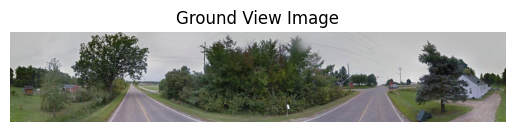

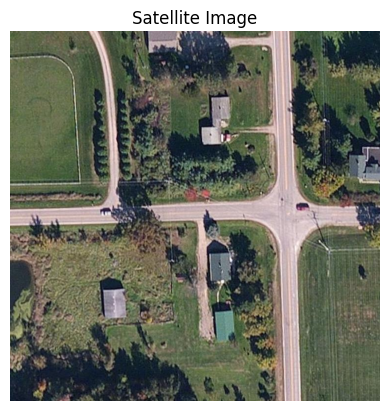

In [5]:
if is_colab():
    ground_view_image_path = '/content/drive/MyDrive/CV_dataset/CVPR_subset/streetview/streetview/panos/0027458.jpg'
    satellite_image_path = '/content/drive/MyDrive/CV_dataset/CVPR_subset/bingmap/bingmap/19/0027458.jpg'
else:
    ground_view_image_path = './CV_dataset/CVPR_subset/streetview/streetview/panos/0027458.jpg'
    satellite_image_path = './CV_dataset/CVPR_subset/bingmap/bingmap/19/0027458.jpg'

ground_img = Image.open(ground_view_image_path).convert('RGB')
aerial_img = Image.open(satellite_image_path).convert('RGB')
# already RGB

#print(f"Ground view image mode: {ground_img.mode}\nSatellite image mode: {aerial_img.mode}")
print(f"Ground view images dimension: {ground_img.size}\nSatellite images dimension: {aerial_img.size}")

plt.figure()
plt.title('Ground View Image')
plt.imshow(ground_img)
plt.axis('off')
plt.show()

plt.figure()
plt.title('Satellite Image')
plt.imshow(aerial_img)
plt.axis('off')
plt.show()

transforms

Transformed ground tensor shape: torch.Size([3, 224, 224])
Transformed aerial tensor shape: torch.Size([3, 224, 224])


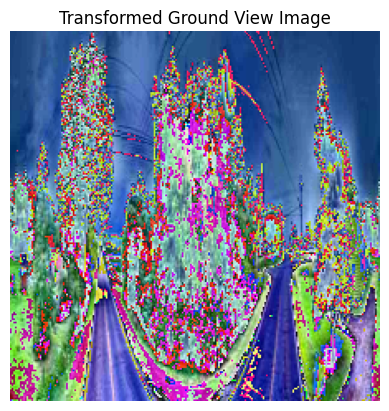

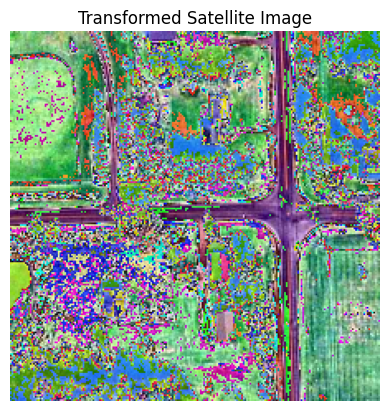

In [ ]:
ground_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # standard ImageNet normalization
])
aerial_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # standard ImageNet normalization
])
# Apply preprocessing
ground_tensor = ground_transform(ground_img)
aerial_tensor = aerial_transform(aerial_img)

# Add batch dimension
ground_input_batch = ground_tensor.unsqueeze(0)
aerial_input_batch = aerial_tensor.unsqueeze(0)
# Move to GPU
ground_input_batch = ground_input_batch.to(device)
aerial_input_batch = aerial_input_batch.to(device)


# VISUALIZATION
print(f"Transformed ground tensor shape: {ground_tensor.shape}")
print(f"Transformed aerial tensor shape: {aerial_tensor.shape}")

# Convert tensors back to PIL Images for visualization
ground_img_transformed = transforms.ToPILImage()(ground_tensor)
aerial_img_transformed = transforms.ToPILImage()(aerial_tensor)

plt.figure()
plt.title('Transformed Ground View Image')
plt.imshow(ground_img_transformed)
plt.axis('off')
plt.show()

plt.figure()
plt.title('Transformed Satellite Image')
plt.imshow(aerial_img_transformed)
plt.axis('off')
plt.show()

## K-Means

### simple k-means

In [6]:
from sklearn.cluster import KMeans

In [18]:
def get_segmap_kmeans(img, colors, num_classes=3, verbose=False):
    """
    img: PIL Image
    num_classes: number of classes for segmentation map
    colors: cluster colors, [[255, 0, 0], [0, 255, 0], ...]
    """
    img_np = np.array(img)
    pixels = img_np.reshape(-1, 3)

    # Apply K-Means clustering to group pixels into classes
    kmeans = KMeans(n_clusters=num_classes, random_state=19)
    kmeans.fit(pixels)
    labels = kmeans.labels_

    # Create segmentation map
    segmented_pixels = np.array([colors[label] for label in labels])
    segmented_img = segmented_pixels.reshape(img_np.shape).astype(np.uint8)

    if verbose:
        print(f"Image shape: {img_np.shape}")
        print(f"Segmented image shape: {segmented_img.shape}")
    
    return segmented_img

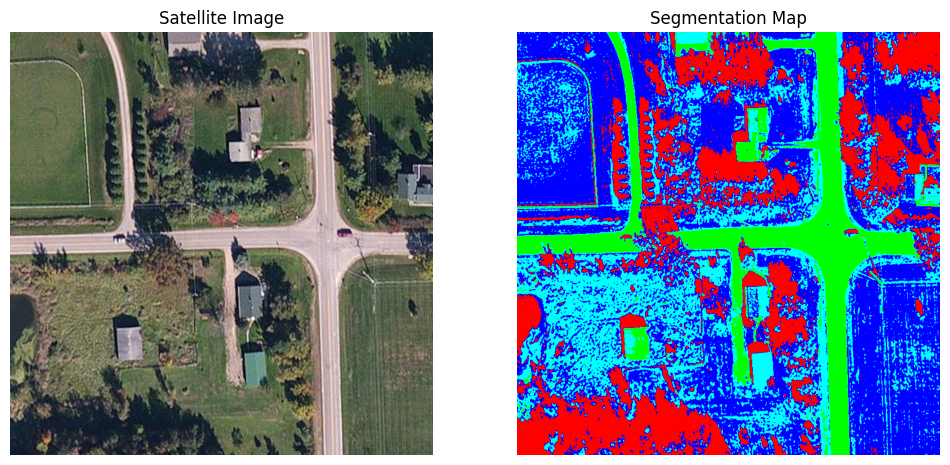

In [19]:
num_classes = 4
cluster_colors = [
    #[255, 255, 0],    # Yellow
    [0, 255, 255],   # Cyan
    [255, 0, 0],    # Red
    [0, 255, 0],    # Green
    [0, 0, 255]   # Blue
]

seg_img = get_segmap_kmeans(aerial_img, cluster_colors, num_classes=num_classes)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Satellite Image')
plt.imshow(aerial_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmentation Map')
plt.imshow(seg_img)
plt.axis('off')
plt.show()

### k-means with class consistency across images

In [9]:
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

In [10]:
def get_consistent_segmap(img, num_classes=4, verbose=False):
    """
    Returns consistent single-channel segmentation map across images
    by sorting clusters based on luminance
    """
    img_np = np.array(img)
    pixels = img_np.reshape(-1, 3).astype(np.float32)

    # Apply K-Means
    kmeans = KMeans(n_clusters=num_classes, random_state=19)
    labels = kmeans.fit_predict(pixels)
    centers = kmeans.cluster_centers_

    # Calculate luminance: Y = 0.299*R + 0.587*G + 0.114*B
    luminance = np.dot(centers, [0.299, 0.587, 0.114])
    
    # Create consistent ordering from dark to light
    sorted_idx = np.argsort(luminance)
    
    # Remap labels using luminance ordering
    label_map = np.zeros_like(labels)
    for new_label, old_label in enumerate(sorted_idx):
        label_map[labels == old_label] = new_label
        
    # Reshape to 2D
    label_map = label_map.reshape(img_np.shape[0], img_np.shape[1]).astype(np.uint8)
    
    if verbose:
        print(f"Luminance order: {luminance[sorted_idx]}")
        print(f"Class distribution: {np.bincount(label_map.flatten())}")
    
    return label_map

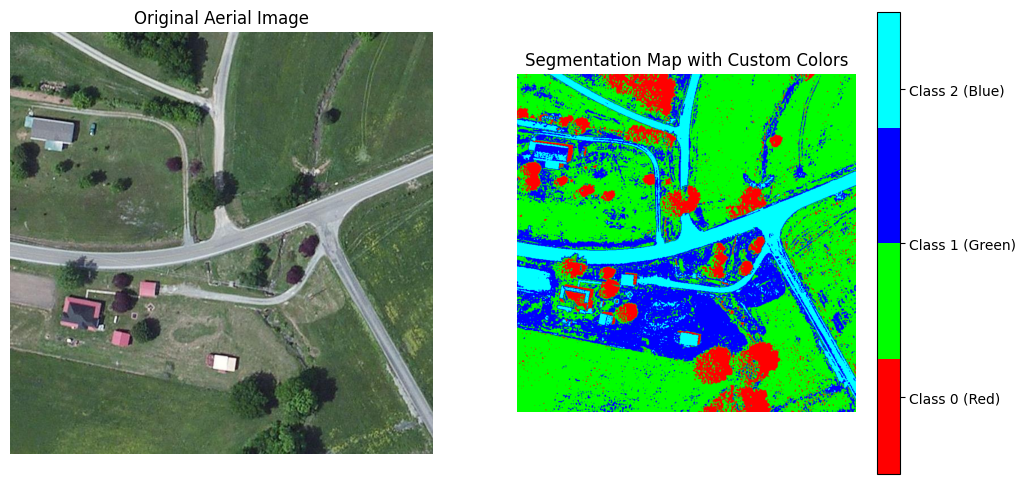

'\n    4 classes:\n        Red: shadows\n        Green: fields\n        Blue: vegetation / buildings\n        Cyan: Roads / buildings\n\n        Problem: buildings not clearly identified\n'

In [23]:
custom_colors = [
    [1, 0, 0],    # Class 0: Red
    [0, 1, 0],    # Class 1: Green
    [0, 0, 1],    # Class 2: Blue
    [0, 1, 1]    # Class 3: Cyan
    #[1, 0, 1]     # Class 4: Pink
]

cmap_custom = ListedColormap(custom_colors)

# Generate label_map (using your existing function)
satellite_image_path = './CV_dataset/CVPR_subset/bingmap/bingmap/19/0019289.jpg'
aerial_img = Image.open(satellite_image_path).convert('RGB')
label_map = get_consistent_segmap(aerial_img, num_classes=4)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Original image
ax[0].imshow(aerial_img)
ax[0].set_title('Original Aerial Image')
ax[0].axis('off')

# Segmentation map with custom colors
seg_display = ax[1].imshow(label_map, cmap=cmap_custom, vmin=0, vmax=3)
ax[1].set_title('Segmentation Map with Custom Colors')
ax[1].axis('off')
# Add colorbar with class labels
cbar = fig.colorbar(seg_display, ax=ax[1], ticks=[0.5, 1.5, 2.5, 3.5])
cbar.ax.set_yticklabels(['Class 0 (Red)',
                         'Class 1 (Green)',
                         'Class 2 (Blue)',
                         'Class 3 (Cyan)'
                        ])
plt.show()

"""
    4 classes:
        Red: shadows
        Green: fields
        Blue: vegetation / buildings
        Cyan: Roads / buildings

        Problem: buildings not clearly identified
"""



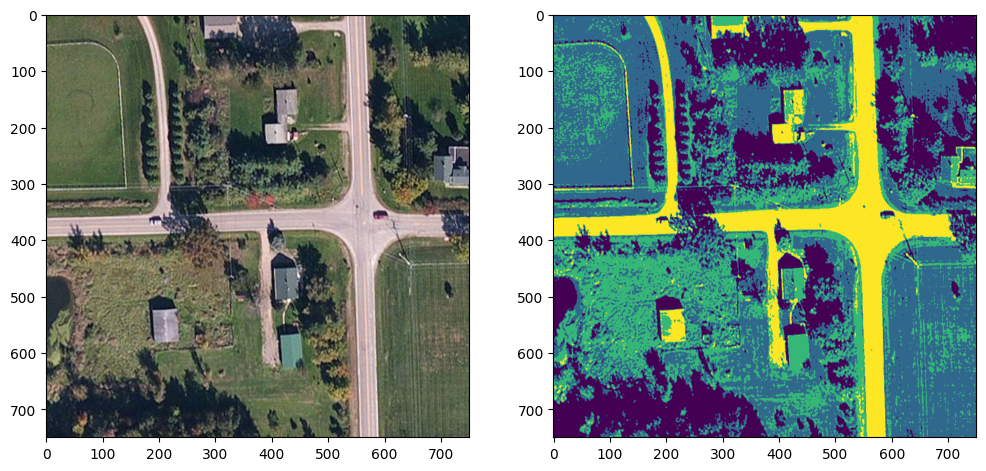

In [ ]:
# VIRDIS COLOR MAP

label_map = get_consistent_segmap(aerial_img, num_classes=4)

# Visual comparison
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(aerial_img)
ax[1].imshow(label_map, cmap='viridis', vmin=0, vmax=3)     # viridis colormap converts integers to colors
plt.show()

## DeepLabv3+

### ResNet101

In [ ]:
%pip install segmentation_models_pytorch -q

In [68]:
import segmentation_models_pytorch as smp
from matplotlib import colors

In [71]:
# Load pre-trained model (DeepLabV3+ with ResNet101 backbone)
model = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=7,  # LoveDA has 7 classes
    activation=None
)

# Load pre-trained weights
checkpoint = torch.load('segmap_assets/best_deeplabv3plus_resnet101_voc_os16.pth', map_location=device, weights_only=False)
state_dict = checkpoint["model_state"]
model.load_state_dict(state_dict)
# Move to device and set eval mode
model = model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for DeepLabV3Plus:
	Missing key(s) in state_dict: "encoder.conv1.weight", "encoder.bn1.weight", "encoder.bn1.bias", "encoder.bn1.running_mean", "encoder.bn1.running_var", "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.0.conv3.weight", "encoder.layer1.0.bn3.weight", "encoder.layer1.0.bn3.bias", "encoder.layer1.0.bn3.running_mean", "encoder.layer1.0.bn3.running_var", "encoder.layer1.0.downsample.0.weight", "encoder.layer1.0.downsample.1.weight", "encoder.layer1.0.downsample.1.bias", "encoder.layer1.0.downsample.1.running_mean", "encoder.layer1.0.downsample.1.running_var", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.1.conv3.weight", "encoder.layer1.1.bn3.weight", "encoder.layer1.1.bn3.bias", "encoder.layer1.1.bn3.running_mean", "encoder.layer1.1.bn3.running_var", "encoder.layer1.2.conv1.weight", "encoder.layer1.2.bn1.weight", "encoder.layer1.2.bn1.bias", "encoder.layer1.2.bn1.running_mean", "encoder.layer1.2.bn1.running_var", "encoder.layer1.2.conv2.weight", "encoder.layer1.2.bn2.weight", "encoder.layer1.2.bn2.bias", "encoder.layer1.2.bn2.running_mean", "encoder.layer1.2.bn2.running_var", "encoder.layer1.2.conv3.weight", "encoder.layer1.2.bn3.weight", "encoder.layer1.2.bn3.bias", "encoder.layer1.2.bn3.running_mean", "encoder.layer1.2.bn3.running_var", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.conv3.weight", "encoder.layer2.0.bn3.weight", "encoder.layer2.0.bn3.bias", "encoder.layer2.0.bn3.running_mean", "encoder.layer2.0.bn3.running_var", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.1.conv3.weight", "encoder.layer2.1.bn3.weight", "encoder.layer2.1.bn3.bias", "encoder.layer2.1.bn3.running_mean", "encoder.layer2.1.bn3.running_var", "encoder.layer2.2.conv1.weight", "encoder.layer2.2.bn1.weight", "encoder.layer2.2.bn1.bias", "encoder.layer2.2.bn1.running_mean", "encoder.layer2.2.bn1.running_var", "encoder.layer2.2.conv2.weight", "encoder.layer2.2.bn2.weight", "encoder.layer2.2.bn2.bias", "encoder.layer2.2.bn2.running_mean", "encoder.layer2.2.bn2.running_var", "encoder.layer2.2.conv3.weight", "encoder.layer2.2.bn3.weight", "encoder.layer2.2.bn3.bias", "encoder.layer2.2.bn3.running_mean", "encoder.layer2.2.bn3.running_var", "encoder.layer2.3.conv1.weight", "encoder.layer2.3.bn1.weight", "encoder.layer2.3.bn1.bias", "encoder.layer2.3.bn1.running_mean", "encoder.layer2.3.bn1.running_var", "encoder.layer2.3.conv2.weight", "encoder.layer2.3.bn2.weight", "encoder.layer2.3.bn2.bias", "encoder.layer2.3.bn2.running_mean", "encoder.layer2.3.bn2.running_var", "encoder.layer2.3.conv3.weight", "encoder.layer2.3.bn3.weight", "encoder.layer2.3.bn3.bias", "encoder.layer2.3.bn3.running_mean", "encoder.layer2.3.bn3.running_var", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.conv3.weight", "encoder.layer3.0.bn3.weight", "encoder.layer3.0.bn3.bias", "encoder.layer3.0.bn3.running_mean", "encoder.layer3.0.bn3.running_var", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.1.conv3.weight", "encoder.layer3.1.bn3.weight", "encoder.layer3.1.bn3.bias", "encoder.layer3.1.bn3.running_mean", "encoder.layer3.1.bn3.running_var", "encoder.layer3.2.conv1.weight", "encoder.layer3.2.bn1.weight", "encoder.layer3.2.bn1.bias", "encoder.layer3.2.bn1.running_mean", "encoder.layer3.2.bn1.running_var", "encoder.layer3.2.conv2.weight", "encoder.layer3.2.bn2.weight", "encoder.layer3.2.bn2.bias", "encoder.layer3.2.bn2.running_mean", "encoder.layer3.2.bn2.running_var", "encoder.layer3.2.conv3.weight", "encoder.layer3.2.bn3.weight", "encoder.layer3.2.bn3.bias", "encoder.layer3.2.bn3.running_mean", "encoder.layer3.2.bn3.running_var", "encoder.layer3.3.conv1.weight", "encoder.layer3.3.bn1.weight", "encoder.layer3.3.bn1.bias", "encoder.layer3.3.bn1.running_mean", "encoder.layer3.3.bn1.running_var", "encoder.layer3.3.conv2.weight", "encoder.layer3.3.bn2.weight", "encoder.layer3.3.bn2.bias", "encoder.layer3.3.bn2.running_mean", "encoder.layer3.3.bn2.running_var", "encoder.layer3.3.conv3.weight", "encoder.layer3.3.bn3.weight", "encoder.layer3.3.bn3.bias", "encoder.layer3.3.bn3.running_mean", "encoder.layer3.3.bn3.running_var", "encoder.layer3.4.conv1.weight", "encoder.layer3.4.bn1.weight", "encoder.layer3.4.bn1.bias", "encoder.layer3.4.bn1.running_mean", "encoder.layer3.4.bn1.running_var", "encoder.layer3.4.conv2.weight", "encoder.layer3.4.bn2.weight", "encoder.layer3.4.bn2.bias", "encoder.layer3.4.bn2.running_mean", "encoder.layer3.4.bn2.running_var", "encoder.layer3.4.conv3.weight", "encoder.layer3.4.bn3.weight", "encoder.layer3.4.bn3.bias", "encoder.layer3.4.bn3.running_mean", "encoder.layer3.4.bn3.running_var", "encoder.layer3.5.conv1.weight", "encoder.layer3.5.bn1.weight", "encoder.layer3.5.bn1.bias", "encoder.layer3.5.bn1.running_mean", "encoder.layer3.5.bn1.running_var", "encoder.layer3.5.conv2.weight", "encoder.layer3.5.bn2.weight", "encoder.layer3.5.bn2.bias", "encoder.layer3.5.bn2.running_mean", "encoder.layer3.5.bn2.running_var", "encoder.layer3.5.conv3.weight", "encoder.layer3.5.bn3.weight", "encoder.layer3.5.bn3.bias", "encoder.layer3.5.bn3.running_mean", "encoder.layer3.5.bn3.running_var", "encoder.layer3.6.conv1.weight", "encoder.layer3.6.bn1.weight", "encoder.layer3.6.bn1.bias", "encoder.layer3.6.bn1.running_mean", "encoder.layer3.6.bn1.running_var", "encoder.layer3.6.conv2.weight", "encoder.layer3.6.bn2.weight", "encoder.layer3.6.bn2.bias", "encoder.layer3.6.bn2.running_mean", "encoder.layer3.6.bn2.running_var", "encoder.layer3.6.conv3.weight", "encoder.layer3.6.bn3.weight", "encoder.layer3.6.bn3.bias", "encoder.layer3.6.bn3.running_mean", "encoder.layer3.6.bn3.running_var", "encoder.layer3.7.conv1.weight", "encoder.layer3.7.bn1.weight", "encoder.layer3.7.bn1.bias", "encoder.layer3.7.bn1.running_mean", "encoder.layer3.7.bn1.running_var", "encoder.layer3.7.conv2.weight", "encoder.layer3.7.bn2.weight", "encoder.layer3.7.bn2.bias", "encoder.layer3.7.bn2.running_mean", "encoder.layer3.7.bn2.running_var", "encoder.layer3.7.conv3.weight", "encoder.layer3.7.bn3.weight", "encoder.layer3.7.bn3.bias", "encoder.layer3.7.bn3.running_mean", "encoder.layer3.7.bn3.running_var", "encoder.layer3.8.conv1.weight", "encoder.layer3.8.bn1.weight", "encoder.layer3.8.bn1.bias", "encoder.layer3.8.bn1.running_mean", "encoder.layer3.8.bn1.running_var", "encoder.layer3.8.conv2.weight", "encoder.layer3.8.bn2.weight", "encoder.layer3.8.bn2.bias", "encoder.layer3.8.bn2.running_mean", "encoder.layer3.8.bn2.running_var", "encoder.layer3.8.conv3.weight", "encoder.layer3.8.bn3.weight", "encoder.layer3.8.bn3.bias", "encoder.layer3.8.bn3.running_mean", "encoder.layer3.8.bn3.running_var", "encoder.layer3.9.conv1.weight", "encoder.layer3.9.bn1.weight", "encoder.layer3.9.bn1.bias", "encoder.layer3.9.bn1.running_mean", "encoder.layer3.9.bn1.running_var", "encoder.layer3.9.conv2.weight", "encoder.layer3.9.bn2.weight", "encoder.layer3.9.bn2.bias", "encoder.layer3.9.bn2.running_mean", "encoder.layer3.9.bn2.running_var", "encoder.layer3.9.conv3.weight", "encoder.layer3.9.bn3.weight", "encoder.layer3.9.bn3.bias", "encoder.layer3.9.bn3.running_mean", "encoder.layer3.9.bn3.running_var", "encoder.layer3.10.conv1.weight", "encoder.layer3.10.bn1.weight", "encoder.layer3.10.bn1.bias", "encoder.layer3.10.bn1.running_mean", "encoder.layer3.10.bn1.running_var", "encoder.layer3.10.conv2.weight", "encoder.layer3.10.bn2.weight", "encoder.layer3.10.bn2.bias", "encoder.layer3.10.bn2.running_mean", "encoder.layer3.10.bn2.running_var", "encoder.layer3.10.conv3.weight", "encoder.layer3.10.bn3.weight", "encoder.layer3.10.bn3.bias", "encoder.layer3.10.bn3.running_mean", "encoder.layer3.10.bn3.running_var", "encoder.layer3.11.conv1.weight", "encoder.layer3.11.bn1.weight", "encoder.layer3.11.bn1.bias", "encoder.layer3.11.bn1.running_mean", "encoder.layer3.11.bn1.running_var", "encoder.layer3.11.conv2.weight", "encoder.layer3.11.bn2.weight", "encoder.layer3.11.bn2.bias", "encoder.layer3.11.bn2.running_mean", "encoder.layer3.11.bn2.running_var", "encoder.layer3.11.conv3.weight", "encoder.layer3.11.bn3.weight", "encoder.layer3.11.bn3.bias", "encoder.layer3.11.bn3.running_mean", "encoder.layer3.11.bn3.running_var", "encoder.layer3.12.conv1.weight", "encoder.layer3.12.bn1.weight", "encoder.layer3.12.bn1.bias", "encoder.layer3.12.bn1.running_mean", "encoder.layer3.12.bn1.running_var", "encoder.layer3.12.conv2.weight", "encoder.layer3.12.bn2.weight", "encoder.layer3.12.bn2.bias", "encoder.layer3.12.bn2.running_mean", "encoder.layer3.12.bn2.running_var", "encoder.layer3.12.conv3.weight", "encoder.layer3.12.bn3.weight", "encoder.layer3.12.bn3.bias", "encoder.layer3.12.bn3.running_mean", "encoder.layer3.12.bn3.running_var", "encoder.layer3.13.conv1.weight", "encoder.layer3.13.bn1.weight", "encoder.layer3.13.bn1.bias", "encoder.layer3.13.bn1.running_mean", "encoder.layer3.13.bn1.running_var", "encoder.layer3.13.conv2.weight", "encoder.layer3.13.bn2.weight", "encoder.layer3.13.bn2.bias", "encoder.layer3.13.bn2.running_mean", "encoder.layer3.13.bn2.running_var", "encoder.layer3.13.conv3.weight", "encoder.layer3.13.bn3.weight", "encoder.layer3.13.bn3.bias", "encoder.layer3.13.bn3.running_mean", "encoder.layer3.13.bn3.running_var", "encoder.layer3.14.conv1.weight", "encoder.layer3.14.bn1.weight", "encoder.layer3.14.bn1.bias", "encoder.layer3.14.bn1.running_mean", "encoder.layer3.14.bn1.running_var", "encoder.layer3.14.conv2.weight", "encoder.layer3.14.bn2.weight", "encoder.layer3.14.bn2.bias", "encoder.layer3.14.bn2.running_mean", "encoder.layer3.14.bn2.running_var", "encoder.layer3.14.conv3.weight", "encoder.layer3.14.bn3.weight", "encoder.layer3.14.bn3.bias", "encoder.layer3.14.bn3.running_mean", "encoder.layer3.14.bn3.running_var", "encoder.layer3.15.conv1.weight", "encoder.layer3.15.bn1.weight", "encoder.layer3.15.bn1.bias", "encoder.layer3.15.bn1.running_mean", "encoder.layer3.15.bn1.running_var", "encoder.layer3.15.conv2.weight", "encoder.layer3.15.bn2.weight", "encoder.layer3.15.bn2.bias", "encoder.layer3.15.bn2.running_mean", "encoder.layer3.15.bn2.running_var", "encoder.layer3.15.conv3.weight", "encoder.layer3.15.bn3.weight", "encoder.layer3.15.bn3.bias", "encoder.layer3.15.bn3.running_mean", "encoder.layer3.15.bn3.running_var", "encoder.layer3.16.conv1.weight", "encoder.layer3.16.bn1.weight", "encoder.layer3.16.bn1.bias", "encoder.layer3.16.bn1.running_mean", "encoder.layer3.16.bn1.running_var", "encoder.layer3.16.conv2.weight", "encoder.layer3.16.bn2.weight", "encoder.layer3.16.bn2.bias", "encoder.layer3.16.bn2.running_mean", "encoder.layer3.16.bn2.running_var", "encoder.layer3.16.conv3.weight", "encoder.layer3.16.bn3.weight", "encoder.layer3.16.bn3.bias", "encoder.layer3.16.bn3.running_mean", "encoder.layer3.16.bn3.running_var", "encoder.layer3.17.conv1.weight", "encoder.layer3.17.bn1.weight", "encoder.layer3.17.bn1.bias", "encoder.layer3.17.bn1.running_mean", "encoder.layer3.17.bn1.running_var", "encoder.layer3.17.conv2.weight", "encoder.layer3.17.bn2.weight", "encoder.layer3.17.bn2.bias", "encoder.layer3.17.bn2.running_mean", "encoder.layer3.17.bn2.running_var", "encoder.layer3.17.conv3.weight", "encoder.layer3.17.bn3.weight", "encoder.layer3.17.bn3.bias", "encoder.layer3.17.bn3.running_mean", "encoder.layer3.17.bn3.running_var", "encoder.layer3.18.conv1.weight", "encoder.layer3.18.bn1.weight", "encoder.layer3.18.bn1.bias", "encoder.layer3.18.bn1.running_mean", "encoder.layer3.18.bn1.running_var", "encoder.layer3.18.conv2.weight", "encoder.layer3.18.bn2.weight", "encoder.layer3.18.bn2.bias", "encoder.layer3.18.bn2.running_mean", "encoder.layer3.18.bn2.running_var", "encoder.layer3.18.conv3.weight", "encoder.layer3.18.bn3.weight", "encoder.layer3.18.bn3.bias", "encoder.layer3.18.bn3.running_mean", "encoder.layer3.18.bn3.running_var", "encoder.layer3.19.conv1.weight", "encoder.layer3.19.bn1.weight", "encoder.layer3.19.bn1.bias", "encoder.layer3.19.bn1.running_mean", "encoder.layer3.19.bn1.running_var", "encoder.layer3.19.conv2.weight", "encoder.layer3.19.bn2.weight", "encoder.layer3.19.bn2.bias", "encoder.layer3.19.bn2.running_mean", "encoder.layer3.19.bn2.running_var", "encoder.layer3.19.conv3.weight", "encoder.layer3.19.bn3.weight", "encoder.layer3.19.bn3.bias", "encoder.layer3.19.bn3.running_mean", "encoder.layer3.19.bn3.running_var", "encoder.layer3.20.conv1.weight", "encoder.layer3.20.bn1.weight", "encoder.layer3.20.bn1.bias", "encoder.layer3.20.bn1.running_mean", "encoder.layer3.20.bn1.running_var", "encoder.layer3.20.conv2.weight", "encoder.layer3.20.bn2.weight", "encoder.layer3.20.bn2.bias", "encoder.layer3.20.bn2.running_mean", "encoder.layer3.20.bn2.running_var", "encoder.layer3.20.conv3.weight", "encoder.layer3.20.bn3.weight", "encoder.layer3.20.bn3.bias", "encoder.layer3.20.bn3.running_mean", "encoder.layer3.20.bn3.running_var", "encoder.layer3.21.conv1.weight", "encoder.layer3.21.bn1.weight", "encoder.layer3.21.bn1.bias", "encoder.layer3.21.bn1.running_mean", "encoder.layer3.21.bn1.running_var", "encoder.layer3.21.conv2.weight", "encoder.layer3.21.bn2.weight", "encoder.layer3.21.bn2.bias", "encoder.layer3.21.bn2.running_mean", "encoder.layer3.21.bn2.running_var", "encoder.layer3.21.conv3.weight", "encoder.layer3.21.bn3.weight", "encoder.layer3.21.bn3.bias", "encoder.layer3.21.bn3.running_mean", "encoder.layer3.21.bn3.running_var", "encoder.layer3.22.conv1.weight", "encoder.layer3.22.bn1.weight", "encoder.layer3.22.bn1.bias", "encoder.layer3.22.bn1.running_mean", "encoder.layer3.22.bn1.running_var", "encoder.layer3.22.conv2.weight", "encoder.layer3.22.bn2.weight", "encoder.layer3.22.bn2.bias", "encoder.layer3.22.bn2.running_mean", "encoder.layer3.22.bn2.running_var", "encoder.layer3.22.conv3.weight", "encoder.layer3.22.bn3.weight", "encoder.layer3.22.bn3.bias", "encoder.layer3.22.bn3.running_mean", "encoder.layer3.22.bn3.running_var", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.conv3.weight", "encoder.layer4.0.bn3.weight", "encoder.layer4.0.bn3.bias", "encoder.layer4.0.bn3.running_mean", "encoder.layer4.0.bn3.running_var", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.1.conv3.weight", "encoder.layer4.1.bn3.weight", "encoder.layer4.1.bn3.bias", "encoder.layer4.1.bn3.running_mean", "encoder.layer4.1.bn3.running_var", "encoder.layer4.2.conv1.weight", "encoder.layer4.2.bn1.weight", "encoder.layer4.2.bn1.bias", "encoder.layer4.2.bn1.running_mean", "encoder.layer4.2.bn1.running_var", "encoder.layer4.2.conv2.weight", "encoder.layer4.2.bn2.weight", "encoder.layer4.2.bn2.bias", "encoder.layer4.2.bn2.running_mean", "encoder.layer4.2.bn2.running_var", "encoder.layer4.2.conv3.weight", "encoder.layer4.2.bn3.weight", "encoder.layer4.2.bn3.bias", "encoder.layer4.2.bn3.running_mean", "encoder.layer4.2.bn3.running_var", "decoder.aspp.0.convs.0.0.weight", "decoder.aspp.0.convs.0.1.weight", "decoder.aspp.0.convs.0.1.bias", "decoder.aspp.0.convs.0.1.running_mean", "decoder.aspp.0.convs.0.1.running_var", "decoder.aspp.0.convs.1.0.0.weight", "decoder.aspp.0.convs.1.0.1.weight", "decoder.aspp.0.convs.1.1.weight", "decoder.aspp.0.convs.1.1.bias", "decoder.aspp.0.convs.1.1.running_mean", "decoder.aspp.0.convs.1.1.running_var", "decoder.aspp.0.convs.2.0.0.weight", "decoder.aspp.0.convs.2.0.1.weight", "decoder.aspp.0.convs.2.1.weight", "decoder.aspp.0.convs.2.1.bias", "decoder.aspp.0.convs.2.1.running_mean", "decoder.aspp.0.convs.2.1.running_var", "decoder.aspp.0.convs.3.0.0.weight", "decoder.aspp.0.convs.3.0.1.weight", "decoder.aspp.0.convs.3.1.weight", "decoder.aspp.0.convs.3.1.bias", "decoder.aspp.0.convs.3.1.running_mean", "decoder.aspp.0.convs.3.1.running_var", "decoder.aspp.0.convs.4.1.weight", "decoder.aspp.0.convs.4.2.weight", "decoder.aspp.0.convs.4.2.bias", "decoder.aspp.0.convs.4.2.running_mean", "decoder.aspp.0.convs.4.2.running_var", "decoder.aspp.0.project.0.weight", "decoder.aspp.0.project.1.weight", "decoder.aspp.0.project.1.bias", "decoder.aspp.0.project.1.running_mean", "decoder.aspp.0.project.1.running_var", "decoder.aspp.1.0.weight", "decoder.aspp.1.1.weight", "decoder.aspp.2.weight", "decoder.aspp.2.bias", "decoder.aspp.2.running_mean", "decoder.aspp.2.running_var", "decoder.block1.0.weight", "decoder.block1.1.weight", "decoder.block1.1.bias", "decoder.block1.1.running_mean", "decoder.block1.1.running_var", "decoder.block2.0.0.weight", "decoder.block2.0.1.weight", "decoder.block2.1.weight", "decoder.block2.1.bias", "decoder.block2.1.running_mean", "decoder.block2.1.running_var", "segmentation_head.0.weight", "segmentation_head.0.bias". 
	Unexpected key(s) in state_dict: "backbone.conv1.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.bn1.num_batches_tracked", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.bn1.num_batches_tracked", "backbone.layer1.0.conv2.weight", "backbone.layer1.0.bn2.weight", "backbone.layer1.0.bn2.bias", "backbone.layer1.0.bn2.running_mean", "backbone.layer1.0.bn2.running_var", "backbone.layer1.0.bn2.num_batches_tracked", "backbone.layer1.0.conv3.weight", "backbone.layer1.0.bn3.weight", "backbone.layer1.0.bn3.bias", "backbone.layer1.0.bn3.running_mean", "backbone.layer1.0.bn3.running_var", "backbone.layer1.0.bn3.num_batches_tracked", "backbone.layer1.0.downsample.0.weight", "backbone.layer1.0.downsample.1.weight", "backbone.layer1.0.downsample.1.bias", "backbone.layer1.0.downsample.1.running_mean", "backbone.layer1.0.downsample.1.running_var", "backbone.layer1.0.downsample.1.num_batches_tracked", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.bn1.num_batches_tracked", "backbone.layer1.1.conv2.weight", "backbone.layer1.1.bn2.weight", "backbone.layer1.1.bn2.bias", "backbone.layer1.1.bn2.running_mean", "backbone.layer1.1.bn2.running_var", "backbone.layer1.1.bn2.num_batches_tracked", "backbone.layer1.1.conv3.weight", "backbone.layer1.1.bn3.weight", "backbone.layer1.1.bn3.bias", "backbone.layer1.1.bn3.running_mean", "backbone.layer1.1.bn3.running_var", "backbone.layer1.1.bn3.num_batches_tracked", "backbone.layer1.2.conv1.weight", "backbone.layer1.2.bn1.weight", "backbone.layer1.2.bn1.bias", "backbone.layer1.2.bn1.running_mean", "backbone.layer1.2.bn1.running_var", "backbone.layer1.2.bn1.num_batches_tracked", "backbone.layer1.2.conv2.weight", "backbone.layer1.2.bn2.weight", "backbone.layer1.2.bn2.bias", "backbone.layer1.2.bn2.running_mean", "backbone.layer1.2.bn2.running_var", "backbone.layer1.2.bn2.num_batches_tracked", "backbone.layer1.2.conv3.weight", "backbone.layer1.2.bn3.weight", "backbone.layer1.2.bn3.bias", "backbone.layer1.2.bn3.running_mean", "backbone.layer1.2.bn3.running_var", "backbone.layer1.2.bn3.num_batches_tracked", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.bn1.num_batches_tracked", "backbone.layer2.0.conv2.weight", "backbone.layer2.0.bn2.weight", "backbone.layer2.0.bn2.bias", "backbone.layer2.0.bn2.running_mean", "backbone.layer2.0.bn2.running_var", "backbone.layer2.0.bn2.num_batches_tracked", "backbone.layer2.0.conv3.weight", "backbone.layer2.0.bn3.weight", "backbone.layer2.0.bn3.bias", "backbone.layer2.0.bn3.running_mean", "backbone.layer2.0.bn3.running_var", "backbone.layer2.0.bn3.num_batches_tracked", "backbone.layer2.0.downsample.0.weight", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.1.bias", "backbone.layer2.0.downsample.1.running_mean", "backbone.layer2.0.downsample.1.running_var", "backbone.layer2.0.downsample.1.num_batches_tracked", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.bn1.num_batches_tracked", "backbone.layer2.1.conv2.weight", "backbone.layer2.1.bn2.weight", "backbone.layer2.1.bn2.bias", "backbone.layer2.1.bn2.running_mean", "backbone.layer2.1.bn2.running_var", "backbone.layer2.1.bn2.num_batches_tracked", "backbone.layer2.1.conv3.weight", "backbone.layer2.1.bn3.weight", "backbone.layer2.1.bn3.bias", "backbone.layer2.1.bn3.running_mean", "backbone.layer2.1.bn3.running_var", "backbone.layer2.1.bn3.num_batches_tracked", "backbone.layer2.2.conv1.weight", "backbone.layer2.2.bn1.weight", "backbone.layer2.2.bn1.bias", "backbone.layer2.2.bn1.running_mean", "backbone.layer2.2.bn1.running_var", "backbone.layer2.2.bn1.num_batches_tracked", "backbone.layer2.2.conv2.weight", "backbone.layer2.2.bn2.weight", "backbone.layer2.2.bn2.bias", "backbone.layer2.2.bn2.running_mean", "backbone.layer2.2.bn2.running_var", "backbone.layer2.2.bn2.num_batches_tracked", "backbone.layer2.2.conv3.weight", "backbone.layer2.2.bn3.weight", "backbone.layer2.2.bn3.bias", "backbone.layer2.2.bn3.running_mean", "backbone.layer2.2.bn3.running_var", "backbone.layer2.2.bn3.num_batches_tracked", "backbone.layer2.3.conv1.weight", "backbone.layer2.3.bn1.weight", "backbone.layer2.3.bn1.bias", "backbone.layer2.3.bn1.running_mean", "backbone.layer2.3.bn1.running_var", "backbone.layer2.3.bn1.num_batches_tracked", "backbone.layer2.3.conv2.weight", "backbone.layer2.3.bn2.weight", "backbone.layer2.3.bn2.bias", "backbone.layer2.3.bn2.running_mean", "backbone.layer2.3.bn2.running_var", "backbone.layer2.3.bn2.num_batches_tracked", "backbone.layer2.3.conv3.weight", "backbone.layer2.3.bn3.weight", "backbone.layer2.3.bn3.bias", "backbone.layer2.3.bn3.running_mean", "backbone.layer2.3.bn3.running_var", "backbone.layer2.3.bn3.num_batches_tracked", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.bn1.num_batches_tracked", "backbone.layer3.0.conv2.weight", "backbone.layer3.0.bn2.weight", "backbone.layer3.0.bn2.bias", "backbone.layer3.0.bn2.running_mean", "backbone.layer3.0.bn2.running_var", "backbone.layer3.0.bn2.num_batches_tracked", "backbone.layer3.0.conv3.weight", "backbone.layer3.0.bn3.weight", "backbone.layer3.0.bn3.bias", "backbone.layer3.0.bn3.running_mean", "backbone.layer3.0.bn3.running_var", "backbone.layer3.0.bn3.num_batches_tracked", "backbone.layer3.0.downsample.0.weight", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.1.bias", "backbone.layer3.0.downsample.1.running_mean", "backbone.layer3.0.downsample.1.running_var", "backbone.layer3.0.downsample.1.num_batches_tracked", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.bn1.num_batches_tracked", "backbone.layer3.1.conv2.weight", "backbone.layer3.1.bn2.weight", "backbone.layer3.1.bn2.bias", "backbone.layer3.1.bn2.running_mean", "backbone.layer3.1.bn2.running_var", "backbone.layer3.1.bn2.num_batches_tracked", "backbone.layer3.1.conv3.weight", "backbone.layer3.1.bn3.weight", "backbone.layer3.1.bn3.bias", "backbone.layer3.1.bn3.running_mean", "backbone.layer3.1.bn3.running_var", "backbone.layer3.1.bn3.num_batches_tracked", "backbone.layer3.2.conv1.weight", "backbone.layer3.2.bn1.weight", "backbone.layer3.2.bn1.bias", "backbone.layer3.2.bn1.running_mean", "backbone.layer3.2.bn1.running_var", "backbone.layer3.2.bn1.num_batches_tracked", "backbone.layer3.2.conv2.weight", "backbone.layer3.2.bn2.weight", "backbone.layer3.2.bn2.bias", "backbone.layer3.2.bn2.running_mean", "backbone.layer3.2.bn2.running_var", "backbone.layer3.2.bn2.num_batches_tracked", "backbone.layer3.2.conv3.weight", "backbone.layer3.2.bn3.weight", "backbone.layer3.2.bn3.bias", "backbone.layer3.2.bn3.running_mean", "backbone.layer3.2.bn3.running_var", "backbone.layer3.2.bn3.num_batches_tracked", "backbone.layer3.3.conv1.weight", "backbone.layer3.3.bn1.weight", "backbone.layer3.3.bn1.bias", "backbone.layer3.3.bn1.running_mean", "backbone.layer3.3.bn1.running_var", "backbone.layer3.3.bn1.num_batches_tracked", "backbone.layer3.3.conv2.weight", "backbone.layer3.3.bn2.weight", "backbone.layer3.3.bn2.bias", "backbone.layer3.3.bn2.running_mean", "backbone.layer3.3.bn2.running_var", "backbone.layer3.3.bn2.num_batches_tracked", "backbone.layer3.3.conv3.weight", "backbone.layer3.3.bn3.weight", "backbone.layer3.3.bn3.bias", "backbone.layer3.3.bn3.running_mean", "backbone.layer3.3.bn3.running_var", "backbone.layer3.3.bn3.num_batches_tracked", "backbone.layer3.4.conv1.weight", "backbone.layer3.4.bn1.weight", "backbone.layer3.4.bn1.bias", "backbone.layer3.4.bn1.running_mean", "backbone.layer3.4.bn1.running_var", "backbone.layer3.4.bn1.num_batches_tracked", "backbone.layer3.4.conv2.weight", "backbone.layer3.4.bn2.weight", "backbone.layer3.4.bn2.bias", "backbone.layer3.4.bn2.running_mean", "backbone.layer3.4.bn2.running_var", "backbone.layer3.4.bn2.num_batches_tracked", "backbone.layer3.4.conv3.weight", "backbone.layer3.4.bn3.weight", "backbone.layer3.4.bn3.bias", "backbone.layer3.4.bn3.running_mean", "backbone.layer3.4.bn3.running_var", "backbone.layer3.4.bn3.num_batches_tracked", "backbone.layer3.5.conv1.weight", "backbone.layer3.5.bn1.weight", "backbone.layer3.5.bn1.bias", "backbone.layer3.5.bn1.running_mean", "backbone.layer3.5.bn1.running_var", "backbone.layer3.5.bn1.num_batches_tracked", "backbone.layer3.5.conv2.weight", "backbone.layer3.5.bn2.weight", "backbone.layer3.5.bn2.bias", "backbone.layer3.5.bn2.running_mean", "backbone.layer3.5.bn2.running_var", "backbone.layer3.5.bn2.num_batches_tracked", "backbone.layer3.5.conv3.weight", "backbone.layer3.5.bn3.weight", "backbone.layer3.5.bn3.bias", "backbone.layer3.5.bn3.running_mean", "backbone.layer3.5.bn3.running_var", "backbone.layer3.5.bn3.num_batches_tracked", "backbone.layer3.6.conv1.weight", "backbone.layer3.6.bn1.weight", "backbone.layer3.6.bn1.bias", "backbone.layer3.6.bn1.running_mean", "backbone.layer3.6.bn1.running_var", "backbone.layer3.6.bn1.num_batches_tracked", "backbone.layer3.6.conv2.weight", "backbone.layer3.6.bn2.weight", "backbone.layer3.6.bn2.bias", "backbone.layer3.6.bn2.running_mean", "backbone.layer3.6.bn2.running_var", "backbone.layer3.6.bn2.num_batches_tracked", "backbone.layer3.6.conv3.weight", "backbone.layer3.6.bn3.weight", "backbone.layer3.6.bn3.bias", "backbone.layer3.6.bn3.running_mean", "backbone.layer3.6.bn3.running_var", "backbone.layer3.6.bn3.num_batches_tracked", "backbone.layer3.7.conv1.weight", "backbone.layer3.7.bn1.weight", "backbone.layer3.7.bn1.bias", "backbone.layer3.7.bn1.running_mean", "backbone.layer3.7.bn1.running_var", "backbone.layer3.7.bn1.num_batches_tracked", "backbone.layer3.7.conv2.weight", "backbone.layer3.7.bn2.weight", "backbone.layer3.7.bn2.bias", "backbone.layer3.7.bn2.running_mean", "backbone.layer3.7.bn2.running_var", "backbone.layer3.7.bn2.num_batches_tracked", "backbone.layer3.7.conv3.weight", "backbone.layer3.7.bn3.weight", "backbone.layer3.7.bn3.bias", "backbone.layer3.7.bn3.running_mean", "backbone.layer3.7.bn3.running_var", "backbone.layer3.7.bn3.num_batches_tracked", "backbone.layer3.8.conv1.weight", "backbone.layer3.8.bn1.weight", "backbone.layer3.8.bn1.bias", "backbone.layer3.8.bn1.running_mean", "backbone.layer3.8.bn1.running_var", "backbone.layer3.8.bn1.num_batches_tracked", "backbone.layer3.8.conv2.weight", "backbone.layer3.8.bn2.weight", "backbone.layer3.8.bn2.bias", "backbone.layer3.8.bn2.running_mean", "backbone.layer3.8.bn2.running_var", "backbone.layer3.8.bn2.num_batches_tracked", "backbone.layer3.8.conv3.weight", "backbone.layer3.8.bn3.weight", "backbone.layer3.8.bn3.bias", "backbone.layer3.8.bn3.running_mean", "backbone.layer3.8.bn3.running_var", "backbone.layer3.8.bn3.num_batches_tracked", "backbone.layer3.9.conv1.weight", "backbone.layer3.9.bn1.weight", "backbone.layer3.9.bn1.bias", "backbone.layer3.9.bn1.running_mean", "backbone.layer3.9.bn1.running_var", "backbone.layer3.9.bn1.num_batches_tracked", "backbone.layer3.9.conv2.weight", "backbone.layer3.9.bn2.weight", "backbone.layer3.9.bn2.bias", "backbone.layer3.9.bn2.running_mean", "backbone.layer3.9.bn2.running_var", "backbone.layer3.9.bn2.num_batches_tracked", "backbone.layer3.9.conv3.weight", "backbone.layer3.9.bn3.weight", "backbone.layer3.9.bn3.bias", "backbone.layer3.9.bn3.running_mean", "backbone.layer3.9.bn3.running_var", "backbone.layer3.9.bn3.num_batches_tracked", "backbone.layer3.10.conv1.weight", "backbone.layer3.10.bn1.weight", "backbone.layer3.10.bn1.bias", "backbone.layer3.10.bn1.running_mean", "backbone.layer3.10.bn1.running_var", "backbone.layer3.10.bn1.num_batches_tracked", "backbone.layer3.10.conv2.weight", "backbone.layer3.10.bn2.weight", "backbone.layer3.10.bn2.bias", "backbone.layer3.10.bn2.running_mean", "backbone.layer3.10.bn2.running_var", "backbone.layer3.10.bn2.num_batches_tracked", "backbone.layer3.10.conv3.weight", "backbone.layer3.10.bn3.weight", "backbone.layer3.10.bn3.bias", "backbone.layer3.10.bn3.running_mean", "backbone.layer3.10.bn3.running_var", "backbone.layer3.10.bn3.num_batches_tracked", "backbone.layer3.11.conv1.weight", "backbone.layer3.11.bn1.weight", "backbone.layer3.11.bn1.bias", "backbone.layer3.11.bn1.running_mean", "backbone.layer3.11.bn1.running_var", "backbone.layer3.11.bn1.num_batches_tracked", "backbone.layer3.11.conv2.weight", "backbone.layer3.11.bn2.weight", "backbone.layer3.11.bn2.bias", "backbone.layer3.11.bn2.running_mean", "backbone.layer3.11.bn2.running_var", "backbone.layer3.11.bn2.num_batches_tracked", "backbone.layer3.11.conv3.weight", "backbone.layer3.11.bn3.weight", "backbone.layer3.11.bn3.bias", "backbone.layer3.11.bn3.running_mean", "backbone.layer3.11.bn3.running_var", "backbone.layer3.11.bn3.num_batches_tracked", "backbone.layer3.12.conv1.weight", "backbone.layer3.12.bn1.weight", "backbone.layer3.12.bn1.bias", "backbone.layer3.12.bn1.running_mean", "backbone.layer3.12.bn1.running_var", "backbone.layer3.12.bn1.num_batches_tracked", "backbone.layer3.12.conv2.weight", "backbone.layer3.12.bn2.weight", "backbone.layer3.12.bn2.bias", "backbone.layer3.12.bn2.running_mean", "backbone.layer3.12.bn2.running_var", "backbone.layer3.12.bn2.num_batches_tracked", "backbone.layer3.12.conv3.weight", "backbone.layer3.12.bn3.weight", "backbone.layer3.12.bn3.bias", "backbone.layer3.12.bn3.running_mean", "backbone.layer3.12.bn3.running_var", "backbone.layer3.12.bn3.num_batches_tracked", "backbone.layer3.13.conv1.weight", "backbone.layer3.13.bn1.weight", "backbone.layer3.13.bn1.bias", "backbone.layer3.13.bn1.running_mean", "backbone.layer3.13.bn1.running_var", "backbone.layer3.13.bn1.num_batches_tracked", "backbone.layer3.13.conv2.weight", "backbone.layer3.13.bn2.weight", "backbone.layer3.13.bn2.bias", "backbone.layer3.13.bn2.running_mean", "backbone.layer3.13.bn2.running_var", "backbone.layer3.13.bn2.num_batches_tracked", "backbone.layer3.13.conv3.weight", "backbone.layer3.13.bn3.weight", "backbone.layer3.13.bn3.bias", "backbone.layer3.13.bn3.running_mean", "backbone.layer3.13.bn3.running_var", "backbone.layer3.13.bn3.num_batches_tracked", "backbone.layer3.14.conv1.weight", "backbone.layer3.14.bn1.weight", "backbone.layer3.14.bn1.bias", "backbone.layer3.14.bn1.running_mean", "backbone.layer3.14.bn1.running_var", "backbone.layer3.14.bn1.num_batches_tracked", "backbone.layer3.14.conv2.weight", "backbone.layer3.14.bn2.weight", "backbone.layer3.14.bn2.bias", "backbone.layer3.14.bn2.running_mean", "backbone.layer3.14.bn2.running_var", "backbone.layer3.14.bn2.num_batches_tracked", "backbone.layer3.14.conv3.weight", "backbone.layer3.14.bn3.weight", "backbone.layer3.14.bn3.bias", "backbone.layer3.14.bn3.running_mean", "backbone.layer3.14.bn3.running_var", "backbone.layer3.14.bn3.num_batches_tracked", "backbone.layer3.15.conv1.weight", "backbone.layer3.15.bn1.weight", "backbone.layer3.15.bn1.bias", "backbone.layer3.15.bn1.running_mean", "backbone.layer3.15.bn1.running_var", "backbone.layer3.15.bn1.num_batches_tracked", "backbone.layer3.15.conv2.weight", "backbone.layer3.15.bn2.weight", "backbone.layer3.15.bn2.bias", "backbone.layer3.15.bn2.running_mean", "backbone.layer3.15.bn2.running_var", "backbone.layer3.15.bn2.num_batches_tracked", "backbone.layer3.15.conv3.weight", "backbone.layer3.15.bn3.weight", "backbone.layer3.15.bn3.bias", "backbone.layer3.15.bn3.running_mean", "backbone.layer3.15.bn3.running_var", "backbone.layer3.15.bn3.num_batches_tracked", "backbone.layer3.16.conv1.weight", "backbone.layer3.16.bn1.weight", "backbone.layer3.16.bn1.bias", "backbone.layer3.16.bn1.running_mean", "backbone.layer3.16.bn1.running_var", "backbone.layer3.16.bn1.num_batches_tracked", "backbone.layer3.16.conv2.weight", "backbone.layer3.16.bn2.weight", "backbone.layer3.16.bn2.bias", "backbone.layer3.16.bn2.running_mean", "backbone.layer3.16.bn2.running_var", "backbone.layer3.16.bn2.num_batches_tracked", "backbone.layer3.16.conv3.weight", "backbone.layer3.16.bn3.weight", "backbone.layer3.16.bn3.bias", "backbone.layer3.16.bn3.running_mean", "backbone.layer3.16.bn3.running_var", "backbone.layer3.16.bn3.num_batches_tracked", "backbone.layer3.17.conv1.weight", "backbone.layer3.17.bn1.weight", "backbone.layer3.17.bn1.bias", "backbone.layer3.17.bn1.running_mean", "backbone.layer3.17.bn1.running_var", "backbone.layer3.17.bn1.num_batches_tracked", "backbone.layer3.17.conv2.weight", "backbone.layer3.17.bn2.weight", "backbone.layer3.17.bn2.bias", "backbone.layer3.17.bn2.running_mean", "backbone.layer3.17.bn2.running_var", "backbone.layer3.17.bn2.num_batches_tracked", "backbone.layer3.17.conv3.weight", "backbone.layer3.17.bn3.weight", "backbone.layer3.17.bn3.bias", "backbone.layer3.17.bn3.running_mean", "backbone.layer3.17.bn3.running_var", "backbone.layer3.17.bn3.num_batches_tracked", "backbone.layer3.18.conv1.weight", "backbone.layer3.18.bn1.weight", "backbone.layer3.18.bn1.bias", "backbone.layer3.18.bn1.running_mean", "backbone.layer3.18.bn1.running_var", "backbone.layer3.18.bn1.num_batches_tracked", "backbone.layer3.18.conv2.weight", "backbone.layer3.18.bn2.weight", "backbone.layer3.18.bn2.bias", "backbone.layer3.18.bn2.running_mean", "backbone.layer3.18.bn2.running_var", "backbone.layer3.18.bn2.num_batches_tracked", "backbone.layer3.18.conv3.weight", "backbone.layer3.18.bn3.weight", "backbone.layer3.18.bn3.bias", "backbone.layer3.18.bn3.running_mean", "backbone.layer3.18.bn3.running_var", "backbone.layer3.18.bn3.num_batches_tracked", "backbone.layer3.19.conv1.weight", "backbone.layer3.19.bn1.weight", "backbone.layer3.19.bn1.bias", "backbone.layer3.19.bn1.running_mean", "backbone.layer3.19.bn1.running_var", "backbone.layer3.19.bn1.num_batches_tracked", "backbone.layer3.19.conv2.weight", "backbone.layer3.19.bn2.weight", "backbone.layer3.19.bn2.bias", "backbone.layer3.19.bn2.running_mean", "backbone.layer3.19.bn2.running_var", "backbone.layer3.19.bn2.num_batches_tracked", "backbone.layer3.19.conv3.weight", "backbone.layer3.19.bn3.weight", "backbone.layer3.19.bn3.bias", "backbone.layer3.19.bn3.running_mean", "backbone.layer3.19.bn3.running_var", "backbone.layer3.19.bn3.num_batches_tracked", "backbone.layer3.20.conv1.weight", "backbone.layer3.20.bn1.weight", "backbone.layer3.20.bn1.bias", "backbone.layer3.20.bn1.running_mean", "backbone.layer3.20.bn1.running_var", "backbone.layer3.20.bn1.num_batches_tracked", "backbone.layer3.20.conv2.weight", "backbone.layer3.20.bn2.weight", "backbone.layer3.20.bn2.bias", "backbone.layer3.20.bn2.running_mean", "backbone.layer3.20.bn2.running_var", "backbone.layer3.20.bn2.num_batches_tracked", "backbone.layer3.20.conv3.weight", "backbone.layer3.20.bn3.weight", "backbone.layer3.20.bn3.bias", "backbone.layer3.20.bn3.running_mean", "backbone.layer3.20.bn3.running_var", "backbone.layer3.20.bn3.num_batches_tracked", "backbone.layer3.21.conv1.weight", "backbone.layer3.21.bn1.weight", "backbone.layer3.21.bn1.bias", "backbone.layer3.21.bn1.running_mean", "backbone.layer3.21.bn1.running_var", "backbone.layer3.21.bn1.num_batches_tracked", "backbone.layer3.21.conv2.weight", "backbone.layer3.21.bn2.weight", "backbone.layer3.21.bn2.bias", "backbone.layer3.21.bn2.running_mean", "backbone.layer3.21.bn2.running_var", "backbone.layer3.21.bn2.num_batches_tracked", "backbone.layer3.21.conv3.weight", "backbone.layer3.21.bn3.weight", "backbone.layer3.21.bn3.bias", "backbone.layer3.21.bn3.running_mean", "backbone.layer3.21.bn3.running_var", "backbone.layer3.21.bn3.num_batches_tracked", "backbone.layer3.22.conv1.weight", "backbone.layer3.22.bn1.weight", "backbone.layer3.22.bn1.bias", "backbone.layer3.22.bn1.running_mean", "backbone.layer3.22.bn1.running_var", "backbone.layer3.22.bn1.num_batches_tracked", "backbone.layer3.22.conv2.weight", "backbone.layer3.22.bn2.weight", "backbone.layer3.22.bn2.bias", "backbone.layer3.22.bn2.running_mean", "backbone.layer3.22.bn2.running_var", "backbone.layer3.22.bn2.num_batches_tracked", "backbone.layer3.22.conv3.weight", "backbone.layer3.22.bn3.weight", "backbone.layer3.22.bn3.bias", "backbone.layer3.22.bn3.running_mean", "backbone.layer3.22.bn3.running_var", "backbone.layer3.22.bn3.num_batches_tracked", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.bn1.num_batches_tracked", "backbone.layer4.0.conv2.weight", "backbone.layer4.0.bn2.weight", "backbone.layer4.0.bn2.bias", "backbone.layer4.0.bn2.running_mean", "backbone.layer4.0.bn2.running_var", "backbone.layer4.0.bn2.num_batches_tracked", "backbone.layer4.0.conv3.weight", "backbone.layer4.0.bn3.weight", "backbone.layer4.0.bn3.bias", "backbone.layer4.0.bn3.running_mean", "backbone.layer4.0.bn3.running_var", "backbone.layer4.0.bn3.num_batches_tracked", "backbone.layer4.0.downsample.0.weight", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.1.bias", "backbone.layer4.0.downsample.1.running_mean", "backbone.layer4.0.downsample.1.running_var", "backbone.layer4.0.downsample.1.num_batches_tracked", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.bn1.num_batches_tracked", "backbone.layer4.1.conv2.weight", "backbone.layer4.1.bn2.weight", "backbone.layer4.1.bn2.bias", "backbone.layer4.1.bn2.running_mean", "backbone.layer4.1.bn2.running_var", "backbone.layer4.1.bn2.num_batches_tracked", "backbone.layer4.1.conv3.weight", "backbone.layer4.1.bn3.weight", "backbone.layer4.1.bn3.bias", "backbone.layer4.1.bn3.running_mean", "backbone.layer4.1.bn3.running_var", "backbone.layer4.1.bn3.num_batches_tracked", "backbone.layer4.2.conv1.weight", "backbone.layer4.2.bn1.weight", "backbone.layer4.2.bn1.bias", "backbone.layer4.2.bn1.running_mean", "backbone.layer4.2.bn1.running_var", "backbone.layer4.2.bn1.num_batches_tracked", "backbone.layer4.2.conv2.weight", "backbone.layer4.2.bn2.weight", "backbone.layer4.2.bn2.bias", "backbone.layer4.2.bn2.running_mean", "backbone.layer4.2.bn2.running_var", "backbone.layer4.2.bn2.num_batches_tracked", "backbone.layer4.2.conv3.weight", "backbone.layer4.2.bn3.weight", "backbone.layer4.2.bn3.bias", "backbone.layer4.2.bn3.running_mean", "backbone.layer4.2.bn3.running_var", "backbone.layer4.2.bn3.num_batches_tracked", "classifier.project.0.weight", "classifier.project.1.weight", "classifier.project.1.bias", "classifier.project.1.running_mean", "classifier.project.1.running_var", "classifier.project.1.num_batches_tracked", "classifier.aspp.convs.0.0.weight", "classifier.aspp.convs.0.1.weight", "classifier.aspp.convs.0.1.bias", "classifier.aspp.convs.0.1.running_mean", "classifier.aspp.convs.0.1.running_var", "classifier.aspp.convs.0.1.num_batches_tracked", "classifier.aspp.convs.1.0.weight", "classifier.aspp.convs.1.1.weight", "classifier.aspp.convs.1.1.bias", "classifier.aspp.convs.1.1.running_mean", "classifier.aspp.convs.1.1.running_var", "classifier.aspp.convs.1.1.num_batches_tracked", "classifier.aspp.convs.2.0.weight", "classifier.aspp.convs.2.1.weight", "classifier.aspp.convs.2.1.bias", "classifier.aspp.convs.2.1.running_mean", "classifier.aspp.convs.2.1.running_var", "classifier.aspp.convs.2.1.num_batches_tracked", "classifier.aspp.convs.3.0.weight", "classifier.aspp.convs.3.1.weight", "classifier.aspp.convs.3.1.bias", "classifier.aspp.convs.3.1.running_mean", "classifier.aspp.convs.3.1.running_var", "classifier.aspp.convs.3.1.num_batches_tracked", "classifier.aspp.convs.4.1.weight", "classifier.aspp.convs.4.2.weight", "classifier.aspp.convs.4.2.bias", "classifier.aspp.convs.4.2.running_mean", "classifier.aspp.convs.4.2.running_var", "classifier.aspp.convs.4.2.num_batches_tracked", "classifier.aspp.project.0.weight", "classifier.aspp.project.1.weight", "classifier.aspp.project.1.bias", "classifier.aspp.project.1.running_mean", "classifier.aspp.project.1.running_var", "classifier.aspp.project.1.num_batches_tracked", "classifier.classifier.0.weight", "classifier.classifier.1.weight", "classifier.classifier.1.bias", "classifier.classifier.1.running_mean", "classifier.classifier.1.running_var", "classifier.classifier.1.num_batches_tracked", "classifier.classifier.3.weight", "classifier.classifier.3.bias". 

In [ ]:
# Correct LoveDA class definitions
CLASS_NAMES = {
    0: "Background",
    1: "Building",
    2: "Road",
    3: "Water",
    4: "Barren",
    5: "Forest",
    6: "Agricultural"
}

# Define proper color mapping (RGB values)
COLOR_MAP = np.array([
    [0, 0, 0],        # Background (Black)
    [255, 0, 0],      # Building (Red)
    [255, 255, 0],    # Road (Yellow)
    [0, 0, 255],      # Water (Blue)
    [159, 129, 183],  # Barren (Purple)
    [0, 255, 0],      # Forest (Green)
    [255, 195, 128]   # Agricultural (Orange)
])

In [ ]:
def preprocess_image(pil_img, target_size=512):
    """Preprocess image for model input"""
    original_size = pil_img.size
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = transform(pil_img).unsqueeze(0).to(device)
    return image, original_size

def generate_segmentation_map(model, image_tensor):
    """Generate segmentation map with proper output handling"""
    with torch.no_grad():
        # Use autocast only for CUDA
        if device.type == 'cuda':
            with torch.cuda.amp.autocast():
                output = model(image_tensor)
        else:
            output = model(image_tensor)
            
        # Handle output dimensions correctly
        if output.shape[1] == 7:  # Check for 7-class output
            seg_map = torch.argmax(output, dim=1).squeeze(0)
        else:
            raise ValueError("Model output has incorrect number of classes")
            
    return seg_map.cpu().numpy().astype(np.uint8)



def postprocess_segmentation(seg_map, original_size):
    """Convert to color image using class mapping"""
    # Create RGB image from class indices
    color_seg = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
    for class_idx in range(7):
        color_seg[seg_map == class_idx] = COLOR_MAP[class_idx]
    
    return Image.fromarray(color_seg).resize(original_size, Image.NEAREST)

def visualize_results(aerial_img, seg_img):
    """Visualize with discrete color mapping"""
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image
    ax[0].imshow(aerial_img)
    ax[0].set_title('Satellite Image')
    ax[0].axis('off')
    
    # Segmentation map
    ax[1].imshow(seg_img)
    ax[1].set_title('Segmentation Map')
    ax[1].axis('off')
    
    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=tuple(c/255 for c in COLOR_MAP[i]), 
        label=CLASS_NAMES[i]
    ) for i in range(7)]
    
    plt.legend(
        handles=legend_elements, 
        loc='center left', 
        bbox_to_anchor=(1, 0.5),
        title="Land Cover Classes"
    )
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Process image
input_tensor, original_size = preprocess_image(aerial_img)
seg_map = generate_segmentation_map(model, input_tensor)
final_seg = postprocess_segmentation(seg_map, original_size)

# Visualize results
visualize_results(aerial_img, final_seg)

## U-Net

### approach with segmentation_models_pytorch (without solaris)

In [50]:
%pip install segmentation-models-pytorch opencv-python -q

Note: you may need to restart the kernel to use updated packages.


In [64]:
import segmentation_models_pytorch as smp

torch.backends.cudnn.benchmark = True  # Optimizes CNN performance

In [65]:
# U-Net with MobileNetV2 encoder (best balance of speed/accuracy)
model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6,  # Based on LoveDA dataset classes
    activation=None
)

# optimizations
model = model.to(device)
model = model.half()  # FP16 for faster computation
model.eval()  # Set to inference mode

# class labels (based on LoveDA dataset)
CLASS_NAMES = {
    0: "Background",
    1: "Building",
    2: "Road",
    3: "Water",
    4: "Barren",
    5: "Forest",
    6: "Agricultural"
}

In [61]:
# ************************************************************************************************************** Preprocess image
def preprocess_image(pil_img):
    # Efficient resizing maintaining aspect ratio
    original_size = pil_img.size
    scale_factor = 512 / max(original_size)
    new_size = (int(original_size[0]*scale_factor), int(original_size[1]*scale_factor))
    
    transform = transforms.Compose([
        transforms.Resize(new_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Convert to FP16 and add batch dimension
    image = transform(pil_img).unsqueeze(0).half().to(device)
    return image, original_size
# **************************************************************************************************************


# ************************************************************************************************************** Generate segmentation map
def generate_segmentation_map(model, image_tensor):
    with torch.no_grad():
        with torch.amp.autocast("cuda"):  # Mixed precision context
            output = model(image_tensor)
        probs = torch.softmax(output, dim=1)
        seg_map = torch.argmax(probs, dim=1).squeeze(0)
    return seg_map.byte().cpu().numpy()  # Convert to uint8 numpy array
# **************************************************************************************************************


# ************************************************************************************************************** Postprocess
def postprocess_segmentation(seg_map, original_size):
    # Convert to PIL and resize to original dimensions
    seg_img = Image.fromarray(seg_map)
    return seg_img.resize(original_size, Image.NEAREST)
# **************************************************************************************************************


# ************************************************************************************************************** Visualization
def visualize_results(aerial_img, seg_map):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    ax[0].imshow(aerial_img)
    ax[0].set_title('Satellite Image')
    ax[0].axis('off')
    
    # Segmentation map
    ax[1].imshow(seg_map, cmap='viridis')
    ax[1].set_title('Segmentation Map')
    ax[1].axis('off')
    
    # Add legend for classes
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=plt.cm.viridis(i/6), 
                       label=CLASS_NAMES[i]) for i in CLASS_NAMES]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
# **************************************************************************************************************

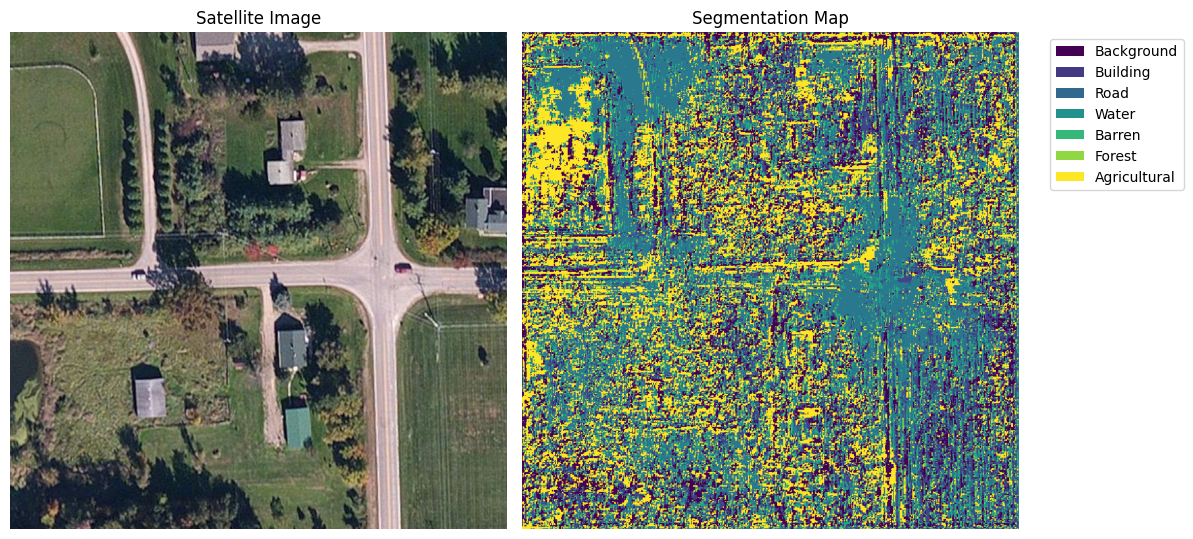

In [62]:
# Process image
input_tensor, original_size = preprocess_image(aerial_img)
seg_map = generate_segmentation_map(model, input_tensor)
final_seg = postprocess_segmentation(seg_map, original_size)

# Visualize results
visualize_results(aerial_img, final_seg)

### reconstruct exactly the model (without solaris)

In [34]:
%pip install segmentation-models-pytorch opencv-python -q

Note: you may need to restart the kernel to use updated packages.


In [29]:
import torch.nn as nn
import torch.nn.functional as F
import cv2

model

In [30]:
class ResNet34Encoder(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self._out_channels = [64, 64, 128, 256, 512]
        self.encoder_stages = nn.ModuleList()
        
        # Initial convolution
        self.encoder_stages.append(nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ))

        # Residual blocks
        self._make_layer(64, 64, 3, stride=1, index=1)   # Layer1
        self._make_layer(64, 128, 4, stride=2, index=2)  # Layer2
        self._make_layer(128, 256, 6, stride=2, index=3) # Layer3
        self._make_layer(256, 512, 3, stride=2, index=4) # Layer4

    def _make_layer(self, in_channels, out_channels, blocks, stride, index):
        layers = []
        # Downsample layer
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        # First block
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample))
        
        # Additional blocks
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        
        stage = nn.Sequential(*layers)
        self.encoder_stages.append(stage)

    def forward(self, x):
        features = []
        for stage in self.encoder_stages:
            x = stage(x)
            features.append(x)
        return features

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class UNet(nn.Module):
    def __init__(self, num_classes=3, decoder_channels=256):
        super().__init__()
        self.encoder = ResNet34Encoder(in_channels=4)
        encoder_channels = self.encoder._out_channels
        
        # Bottleneck layers
        self.bottlenecks = nn.ModuleList([
            self._make_bottleneck(ch, decoder_channels) for ch in reversed(encoder_channels)
        ])
        
        # Decoder stages
        self.decoder_stages = nn.ModuleList()
        for i in range(len(encoder_channels) - 1):
            self.decoder_stages.append(nn.Sequential(
                nn.Conv2d(decoder_channels*2, decoder_channels, kernel_size=3, padding=1, bias=False),
                #nn.Conv2d(decoder_channels, decoder_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(decoder_channels),
                nn.ReLU(inplace=True)
            ))
        
        # Final layers
        self.last_upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(decoder_channels, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_bottleneck(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        encoder_features = self.encoder(x)
        
        # Process through bottlenecks
        features = []
        for i, feat in enumerate(reversed(encoder_features)):
            features.append(self.bottlenecks[i](feat))
        
        # Decoder with skip connections
        x = features[0]
        for i in range(len(self.decoder_stages)):
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)

            # Get skip connection and resize if needed
            skip = features[i+1]
            if skip.shape[-2:] != x.shape[-2:]:
                skip = F.interpolate(skip, size=x.shape[-2:], mode='bilinear', align_corners=True)

            x = torch.cat([x, skip], dim=1)
            #x = torch.cat([x, features[i+1]], dim=1)
            
            x = self.decoder_stages[i](x)
        
        # Final processing
        x = self.last_upsample(x)
        return self.final(x)

# Initialize and load weights
model = UNet(num_classes=3)

# Load state dict with strict=False to ignore missing keys
state_dict = torch.load('segmap_assets/selimsef_spacenet4_resnet34unet_solaris_weights.pth', map_location=device)
model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()

UNet(
  (encoder): ResNet34Encoder(
    (encoder_stages): ModuleList(
      (0): Sequential(
        (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

Output min: -571698.25 max: 287775.625 mean: -31129.70703125
Output shape: torch.Size([1, 3, 384, 384])


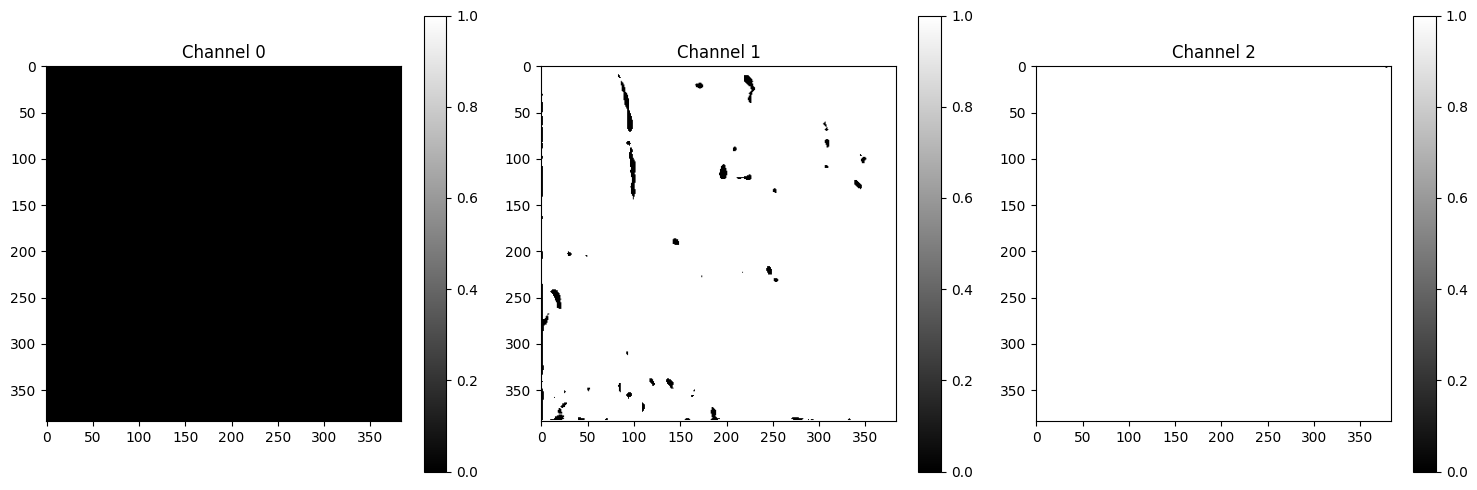

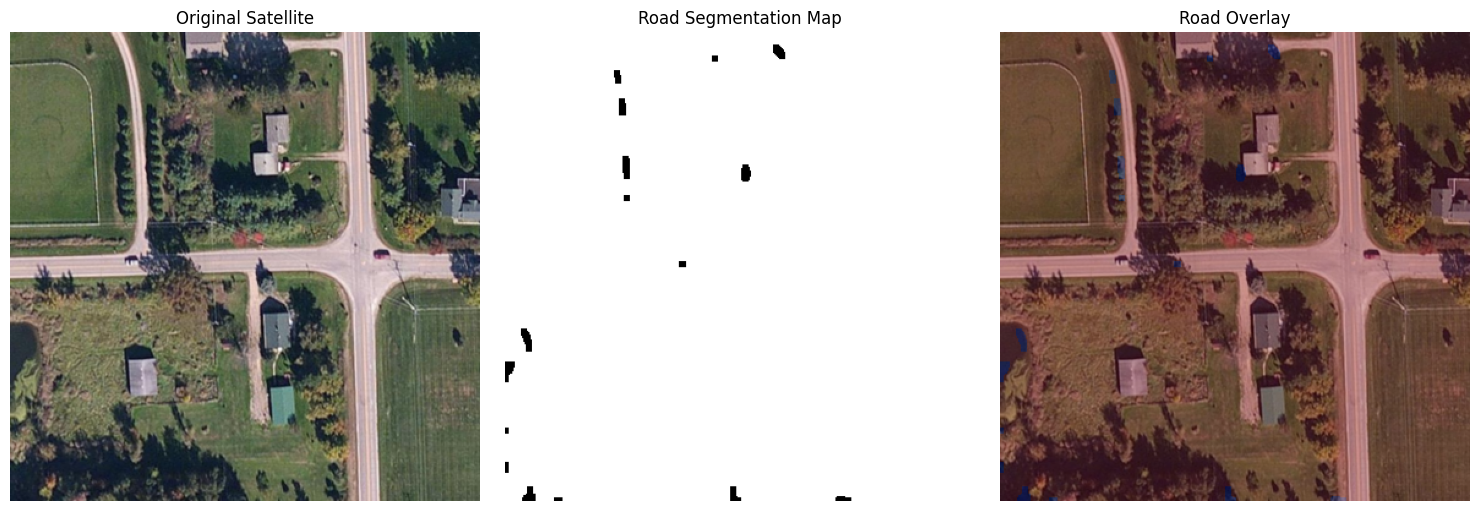

In [41]:
# *****************************************************************************************************************
# Preprocessing function
def preprocess_unet(image):
    # # reshape satellite image to 256x256
    # img_resized = image.resize((256, 256), Image.BILINEAR)
    # img_np = np.array(img_resized)
    img_np = np.array(image)

    # Add Near-Infrared channel if missing (use red channel as placeholder)
    if img_np.shape[2] == 3:
        nir = img_np[..., 0].copy()  # Use red channel as NIR proxy
        img_np = np.dstack([img_np, nir])
        #img_np = np.concatenate([img_np, np.zeros(img_np.shape[:2] + (1,), dtype=img_np.dtype)], axis=2)

    # Scale to 0-65535 (as model expects)
    img_np = img_np.astype(np.float32)
    img_np *= (65535 / 255)
    
    # Normalize with ImageNet stats
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((384, 384)),
        transforms.Normalize(mean=[0.006479, 0.009328, 0.01123, 0.02082], std=[0.004986, 0.004964, 0.004950, 0.004878])
    ])
    return transform(img_np).unsqueeze(0)  # Add batch dimension
    

# def preprocess_unet(image):
#     arr = np.array(image)
    
#     if arr.ndim == 2:  # Grayscale
#         arr = np.stack([arr]*3, axis=-1)
    
#     # Add Near-Infrared channel if missing (use red channel as placeholder)
#     if arr.shape[2] == 3:
#         # Use red channel as NIR placeholder (better than zeros)
#         nir = arr[..., 0].copy()  # Use red channel as NIR proxy
#         arr = np.dstack([arr, nir])
#         #arr = np.concatenate([arr, np.zeros(arr.shape[:2] + (1,), dtype=arr.dtype)], axis=2)
#     image = Image.fromarray(arr)
    
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((384, 384)),
#         transforms.Normalize(mean=[0.006479, 0.009328, 0.01123, 0.02082], std=[0.004986, 0.004964, 0.004950, 0.004878])
#     ])
#     return transform(Image.fromarray(arr)).unsqueeze(0)
#     #return transform(image).unsqueeze(0)
# *****************************************************************************************************************


# *****************************************************************************************************************
# Postprocessing function with adaptive thresholding
def postprocess_mask(prob_mask, original_size):
    # Combine road and intersection channels
    road_mask = 0.7 * prob_mask[1] + 0.3 * prob_mask[2]
    resized = cv2.resize(road_mask, original_size, interpolation=cv2.INTER_LINEAR)
    
    # Adaptive thresholding
    binary = np.zeros_like(resized, dtype=np.uint8)
    binary[resized > 0.2] = 255  # Lower threshold
    
    # Clean artifacts
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    return cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)


# # Postprocessing function
# def postprocess_mask(output, original_size):
#     # Apply sigmoid activation to get probabilities
#     prob_mask = torch.sigmoid(output)
    
#     # Select road channel (index 1) - adjust if needed for your model
#     road_mask = prob_mask[0, 1].cpu().numpy()  # Shape: (384, 384)
    
#     # Threshold and convert to uint8
#     binary_mask = (road_mask > 0.5).astype(np.uint8) * 255
    
#     # Resize to original dimensions (width, height)
#     resized_mask = cv2.resize(binary_mask, original_size, interpolation=cv2.INTER_NEAREST)
    
#     # Clean small artifacts
#     kernel = np.ones((5, 5), np.uint8)
#     cleaned_mask = cv2.morphologyEx(resized_mask, cv2.MORPH_OPEN, kernel)
#     cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)
    
#     return cleaned_mask
# *****************************************************************************************************************


# *****************************************************************************************************************
########################################################################## DEBUG
# Visualize all channels
def visualize_channels(prob_mask, original_size):
    # Resize each channel to original size
    resized_channels = []
    for i in range(prob_mask.shape[0]):
        channel = cv2.resize(prob_mask[i], original_size, interpolation=cv2.INTER_NEAREST)
        resized_channels.append(channel)
    
    # Plot all channels
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        # plt.imshow(resized_channels[i], cmap='hot', vmin=0, vmax=1)
        plt.imshow(resized_channels[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'Channel {i}')
        plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    return resized_channels
########################################################################## DEBUG
# *****************************************************************************************************************


# *****************************************************************************************************************
# Process satellite image
def generate_segmap(img):
    original_size = img.size    # (width, height)
    
    # Preprocess
    input_tensor = preprocess_unet(img).to(device)
    
    # Predict
    with torch.no_grad():
        #output = model_unet(input_tensor)
        output = model(input_tensor)
        
        ########################################## DEBUG
        print("Output min:", output.min().item(), 
              "max:", output.max().item(),
              "mean:", output.mean().item())
        print("Output shape:", output.shape)
        ########################################## DEBUG
    
    # Postprocess
    # road_mask = postprocess_mask(output, original_size)
    # return np.array(img), road_mask

    ########################################## DEBUG
    # Get probability masks for all channels
    prob_mask = torch.sigmoid(output)[0].cpu().numpy()

    # DEBUG: Visualize all channels
    channel_masks = visualize_channels(prob_mask, original_size)
    
    # Assuming channel 0 is background, channel 1 is roads, channel 2 is intersections
    road_mask = channel_masks[1]  # Try different channels here
    
    # Threshold and convert to uint8
    binary_mask = (road_mask > 0.3).astype(np.uint8) * 255
    
    # Clean small artifacts
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    
    return np.array(img), cleaned_mask
    ########################################## DEBUG
# *****************************************************************************************************************





# Run segmentation
img_resized = aerial_img.resize((384, 384), Image.BILINEAR)
sat_img, mask = generate_segmap(img_resized)
#sat_img, mask = generate_segmap(aerial_img)

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(sat_img)
plt.title('Original Satellite')
plt.axis('off')

plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('Road Segmentation Map')
plt.axis('off')

plt.subplot(133)
plt.imshow(sat_img)
plt.imshow(mask, alpha=0.3, cmap='jet')
plt.title('Road Overlay')
plt.axis('off')
plt.tight_layout()
plt.show()

### with solaris

In [20]:
#%pip install solaris -q

import solaris as sol
#from solaris.nets.datagen import make_data_generator
from solaris.nets import TorchUNet

ImportError: cannot import name 'TorchUNet' from 'solaris.nets' (/home/filippo/miniconda3/envs/solaris/lib/python3.7/site-packages/solaris/nets/__init__.py)

In [22]:
aerial_img_np = np.array(aerial_img)

model_unet = sol.nets.load_model(
    model_arch='unet',
    encoder_name='resnet34',
    encoder_weights='imagenet',
    classes=3,  # or 7, depending on your weights
    activation=None,
    weights_path='segmap_assets/selimsef_spacenet4_resnet34unet_solaris_weights.pth',
    device=device
)
model_unet.eval()

# # Initialize Solaris U-Net model
# model_unet = sol.nets.train.TrainSegModel(
#     architecture='unet',  # U-Net architecture
#     backbone='resnet34',   # ResNet34 backbone
#     pretrained=True,       # Use ImageNet pretrained weights
#     num_classes=7,         # Binary segmentation (roads/buildings)
#     learning_rate=0.001    # Default LR (not used for inference)
# )
# # Load SpaceNet4 weights
# model_unet.load_state_dict(torch.load('segmap_assets/selimsef_spacenet4_resnet34unet_solaris_weights.pth', map_location=device))
# model_unet.eval()  # Set to evaluation mode



# Preprocess image
preprocessor = sol.utils.data.SegmentationTiler(
    tile_size=(512, 512),
    overlap=0.1,           # 10% overlap to avoid edge artifacts
    image_type='rgb'
)
tiles, tile_metadata = preprocessor.tile(aerial_img_np)



# Predict segmentation masks
segmentation = np.zeros(aerial_img_np.shape[:2], dtype=np.uint8)
for i, tile in enumerate(tiles):
    tile_tensor = torch.tensor(tile).permute(2, 0, 1).float().unsqueeze(0) / 255.0
    with torch.no_grad():
        pred = torch.sigmoid(model_unet(tile_tensor)).squeeze().numpy()
    tile_mask = (pred > 0.5).astype(np.uint8) * 255
    segmentation = preprocessor.untile(
        tile_mask, 
        i, 
        tile_metadata, 
        output_shape=segmentation.shape
    )

# Post-process to remove small artifacts
segmentation_cleaned = sol.utils.misc.clean_segmentation(
    segmentation,
    min_area=100,          # Remove objects smaller than 100px
    fill_holes=True
)

# Visualize results
plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(aerial_img_np)
plt.title('Original Satellite Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(segmentation, cmap='gray')
plt.title('U-Net Raw Segmentation')
plt.axis('off')

plt.subplot(133)
plt.imshow(segmentation_cleaned, cmap='gray')
plt.title('Cleaned Segmentation')
plt.axis('off')
plt.tight_layout()
plt.show()

AttributeError: module 'solaris.nets' has no attribute 'load_model'

## SegNet
Problem: No pre-trained weights for satellite images

In [8]:
%pip install pillow opencv-python -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch.nn as nn
import cv2
from model import SegNet

ModuleNotFoundError: No module named 'model'

In [ ]:
PATCH_SIZE = 256
NUM_CLASSES = 5  # Background, Road, Vegetation, Building, Water
MODEL_PATH = "./segmap_assets/segnet_satellite.pth"  # Pre-trained weights

CLASS_COLORS = np.array([
    [0, 0, 0],       # Background (Black)
    [255, 0, 0],     # Road (Red)
    [0, 255, 0],     # Vegetation (Green)
    [0, 0, 255],     # Building (Blue)
    [0, 255, 255]    # Water (Cyan)
])

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES):
        super(SegNet, self).__init__()
        # Encoder (VGG16 backbone)
        self.enc1 = self._block(in_channels, 64)
        self.enc2 = self._block(64, 128)
        self.enc3 = self._block(128, 256)
        self.enc4 = self._block(256, 512)
        self.enc5 = self._block(512, 512)
        
        # Decoder with pooling indices
        self.dec5 = self._block(512, 512)
        self.dec4 = self._block(512, 256)
        self.dec3 = self._block(256, 128)
        self.dec2 = self._block(128, 64)
        self.dec1 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
    
    def _block(self, in_filters, out_filters):
        return nn.Sequential(
            nn.Conv2d(in_filters, out_filters, 3, padding=1),
            nn.BatchNorm2d(out_filters),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, return_indices=True)
        )
    
    def forward(self, x):
        # Encoder
        x, idx1 = self.enc1(x)
        x, idx2 = self.enc2(x)
        x, idx3 = self.enc3(x)
        x, idx4 = self.enc4(x)
        x, idx5 = self.enc5(x)
        
        # Decoder
        x = nn.MaxUnpool2d(2, 2)(x, idx5)
        x = self.dec5(x)
        x = nn.MaxUnpool2d(2, 2)(x, idx4)
        x = self.dec4(x)
        x = nn.MaxUnpool2d(2, 2)(x, idx3)
        x = self.dec3(x)
        x = nn.MaxUnpool2d(2, 2)(x, idx2)
        x = self.dec2(x)
        x = nn.MaxUnpool2d(2, 2)(x, idx1)
        x = self.dec1(x)
        return x


In [ ]:
model = SegNet()
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
model.to(device)

In [ ]:
# *********************************************************************** Image Preprocessing
def preprocess(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)



# *********************************************************************** Patch-Based Segmentation
def segment_image(image, model):
    width, height = image.size
    output = torch.zeros(1, NUM_CLASSES, height, width)
    count_map = torch.zeros(height, width)
    
    # Split into patches
    for y in range(0, height, PATCH_SIZE):
        for x in range(0, width, PATCH_SIZE):
            patch = image.crop((x, y, x+PATCH_SIZE, y+PATCH_SIZE))
            patch_tensor = preprocess(patch).to(device)
            
            with torch.no_grad():
                pred = model(patch_tensor)
            
            # Merge predictions
            output[:, :, y:y+PATCH_SIZE, x:x+PATCH_SIZE] += pred.cpu()
            count_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE] += 1
    
    # Average overlapping regions
    output /= count_map
    return torch.argmax(output, dim=1).squeeze(0).numpy()



# *********************************************************************** Post-processing with CRFs
def apply_crf(image, segmentation):
    import pydensecrf.densecrf as dcrf
    from pydensecrf.utils import unary_from_labels
    
    # Setup CRF
    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], NUM_CLASSES)
    u = unary_from_labels(segmentation, NUM_CLASSES, gt_prob=0.7)
    d.setUnaryEnergy(u)
    
    # Add color-independent smoothing
    d.addPairwiseGaussian(sxy=3, compat=3)
    # Add color-dependent smoothing
    d.addPairwiseBilateral(sxy=50, srgb=13, rgbim=image, compat=5)
    
    # Inference
    return np.argmax(d.inference(5), axis=0).reshape(image.shape[:2])



# *********************************************************************** Generate Segmentation Map
def generate_segmentation_map(img):
    # Segment
    seg_mask = segment_image(img, model)
    
    # Refine with CRFs (optional but recommended)
    np_image = np.array(img)
    seg_mask_refined = apply_crf(np_image, seg_mask)
    
    # Convert to color map
    color_mask = CLASS_COLORS[seg_mask_refined]
    return Image.fromarray(color_mask.astype('uint8'))

In [ ]:
seg_map = generate_segmentation_map(aerial_img)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(Image.open(satellite_image_path))
ax[0].set_title('Original Image')
ax[1].imshow(seg_map)
ax[1].set_title('Segmentation Map')
plt.savefig('result.jpg', bbox_inches='tight')
plt.show()

## YOLO

## SAM

### SAM

In [7]:
%pip install segment_anything -q

Note: you may need to restart the kernel to use updated packages.


In [14]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [9]:
# download checkpoint file
if is_colab():
    # For vit_b model
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

    # For vit_l model
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

    # For vit_h model (requires more memory)
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [23]:
# load model
model_type = "vit_l"        # vit_b: 3m 11s - vit_l: - vit_h:

if model_type == "vit_b":
    checkpoint_path = "segmap_assets/sam_vit_b_01ec64.pth"
elif model_type == "vit_l":
    checkpoint_path = "segmap_assets/sam_vit_l_0b3195.pth"
elif model_type == "vit_h":
    checkpoint_path = "segmap_assets/sam_vit_h_4b8939.pth"
else:
    print("Error: wrong model type")
    
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)



def get_segmap(img, model):
    # Create mask generator
    mask_generator = SamAutomaticMaskGenerator(
        model=model,
        points_per_side=32,   # More points increase detail but slow inference
        pred_iou_thresh=0.8,  # Filter low-confidence masks
        stability_score_thresh=0.9,   # Discard unstable segments
        min_mask_region_area=50,   # Remove small segments

        # crop_n_layers=2,              # Processes image in overlapping crops at multiple scales (higher increases complexity)
        # crop_n_points_downscale_factor=1,
        # box_nms_thresh=0.7,           # Reduce mask overlap
        # points_per_batch=64           # Improve memory efficiency
    )

    # Generate masks
    masks = mask_generator.generate(img)

    # Create segmentation map
    seg_map = np.zeros(img.shape[:2], dtype=np.uint32)
    for i, mask_data in enumerate(masks):
        seg_map[mask_data['segmentation']] = i + 1  # Start IDs from 1

    return seg_map

Image shape: (750, 750, 3)
Segmentation mask shape: (750, 750)


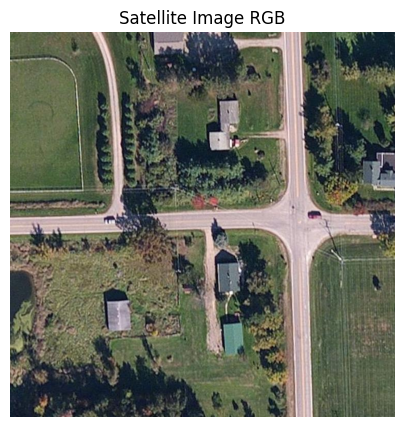

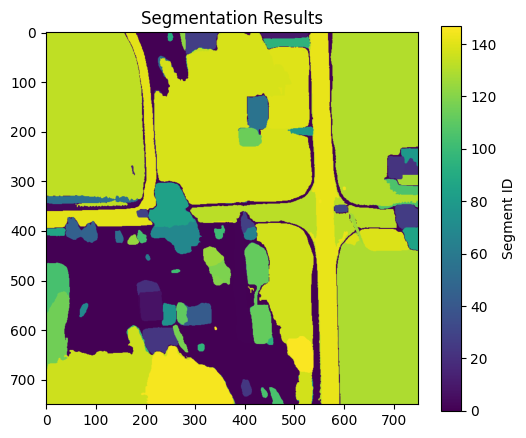

In [24]:
aerial_img_np = np.array(aerial_img)
seg_map = get_segmap(aerial_img_np, sam)
print(f"Image shape: {aerial_img_np.shape}\nSegmentation mask shape: {seg_map.shape}")
#print("Unique segments:", np.unique(seg_map))

# Visualize
plt.figure(figsize=(6, 5))
plt.title('Satellite Image RGB')
plt.imshow(aerial_img_np)
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(seg_map, cmap='viridis')
plt.colorbar(label='Segment ID')
plt.title('Segmentation Results')
plt.show()

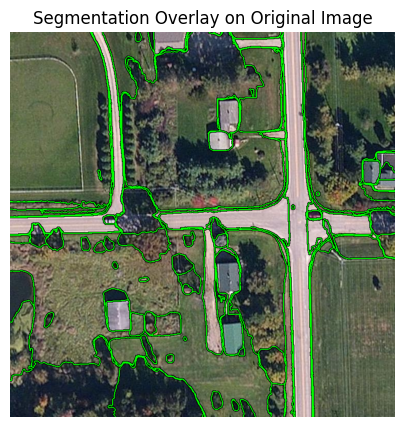

In [25]:
from skimage.segmentation import mark_boundaries

# Create boundary overlay
boundary_image = mark_boundaries(
    aerial_img_np,
    seg_map,
    color=(0, 1, 0),  # Green boundaries (RGB values 0-1)
    mode='thick',      # Thicker boundaries
    outline_color=(0, 0, 0)  # Black outline for better contrast
)

# Display result
plt.figure(figsize=(6, 5))
plt.imshow(boundary_image)
plt.title('Segmentation Overlay on Original Image')
plt.axis('off')
plt.show()

### SAMGeo

In [6]:
%pip install segment-geospatial leafmap localtileserver -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

interactive map

In [ ]:
m = leafmap.Map(center=[37.8713, -122.2580], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

In [9]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-122.2667, 37.8682, -122.2521, 37.8741]

In [ ]:
image = satellite_image_path

m.layers[-1].visible = False
#m.add_raster(image, layer_name="Image")
m.add_image(image, layer_name="Image")
m

model

## Model from huggingface
https://huggingface.co/abcd1334/Satellite_Segmentation

In [ ]:
%pip install opencv-python tensorflow -q

In [7]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose

In [9]:
"""
Load model removing 'groups' arguments.
Groups parameter with value 1 is equivalent to standard convolution (no grouping), so it's safe to remove.
"""
class CustomConv2DTranspose(Conv2DTranspose):
    def __init__(self, *args, **kwargs):
        # Remove 'groups' argument
        kwargs.pop('groups', None)
        super().__init__(*args, **kwargs)

# Load pre-trained model
model = tf.keras.models.load_model(
    'segmap_assets/satellite_segmentation_full.h5',
    custom_objects={'Conv2DTranspose': CustomConv2DTranspose}
)
#model = tf.keras.models.load_model('segmap_assets/satellite_segmentation_full.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


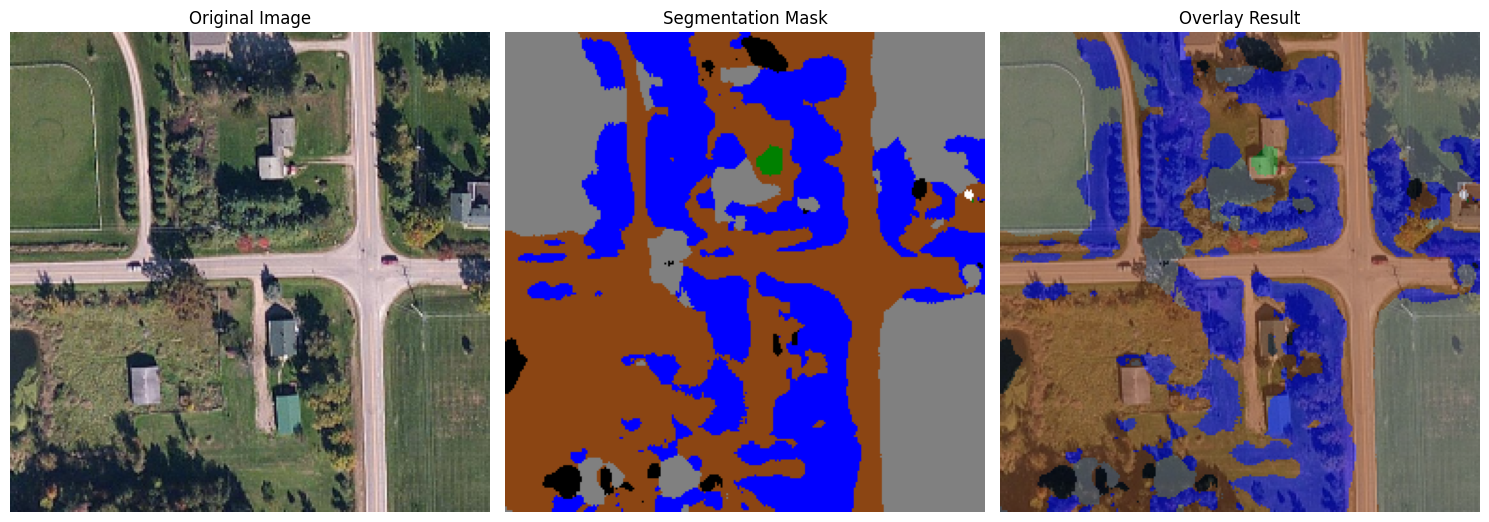

array([[[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]],

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]],

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]],

       ...,

       [[128, 128, 128],
        [139,  69,  19],
        [139,  69,  19],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]],

       [[128, 128, 128],
        [139,  69,  19],
        [139,  69,  19],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]],

       [[128, 128, 128],
        [128, 128, 128],
        [128, 128, 128],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]]

In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU usage

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose
from matplotlib import pyplot as plt

# Custom layer to handle compatibility
class CustomConv2DTranspose(Conv2DTranspose):
    def __init__(self, *args, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(*args, **kwargs)

# Load model with CPU fallback
with tf.device('/CPU:0'):  # Force CPU usage
    model = tf.keras.models.load_model(
        'segmap_assets/satellite_segmentation_full.h5',
        custom_objects={'Conv2DTranspose': CustomConv2DTranspose}
    )

# Define class information
CLASS_NAMES = ['Building', 'Land', 'Road', 'Vegetation', 'Water', 'Unlabeled']
CLASS_COLORS = [
    [128, 128, 128],    # Building - Gray
    [139, 69, 19],      # Land - Brown
    [0, 0, 0],          # Road - Black
    [0, 128, 0],        # Vegetation - Green
    [0, 0, 255],        # Water - Blue
    [255, 255, 255]     # Unlabeled - White
]

# Load and preprocess image
def preprocess_image(image_path):
    # Read image in RGB format
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize to model's expected input shape
    input_shape = model.input_shape[1:3]  # Get (height, width)
    resized = cv2.resize(image, (input_shape[1], input_shape[0]))
    
    # Normalize pixel values to [0, 1]
    normalized = resized / 255.0
    
    # Add batch dimension
    return np.expand_dims(normalized, axis=0), resized

# Make predictions with CPU enforcement
def predict(image_path):
    input_tensor, original_image = preprocess_image(image_path)
    with tf.device('/CPU:0'):  # Ensure prediction uses CPU
        prediction = model.predict(input_tensor)
    return np.squeeze(prediction), original_image

# Process model output
def create_segmentation_mask(prediction):
    # Get class with highest probability per pixel
    class_mask = np.argmax(prediction, axis=-1)
    
    # Convert class IDs to RGB colors
    height, width = class_mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_id, color in enumerate(CLASS_COLORS):
        colored_mask[class_mask == class_id] = color
    
    return colored_mask, class_mask

# Main processing function
def segment_image(image_path, output_path=None):
    # Generate predictions
    raw_pred, original_img = predict(image_path)
    
    # Create visualization mask
    colored_mask, class_mask = create_segmentation_mask(raw_pred)
    
    # Display results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(colored_mask)
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(original_img)
    plt.imshow(colored_mask, alpha=0.5)  # Overlay with transparency
    plt.title('Overlay Result')
    plt.axis('off')
    
    plt.tight_layout()
    
    # Save output if path is provided
    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(colored_mask, cv2.COLOR_RGB2BGR))
        print(f"Saved segmentation mask to {output_path}")
    
    plt.show()
    return colored_mask

# Usage example
segment_image(satellite_image_path)

# Implement for all dataset